In [527]:
!pip3 install --upgrade google-cloud
!pip3 install --upgrade google-cloud-bigquery
!pip3 install --upgrade google-cloud-storage
!pip3 install db-dtypes
!pip3 install 'google-cloud-bigquery[pandas]'
!pip3 install numpy
!pip3 install pandas
!pip3 install google.cloud
!pip3 install scipy
!pip3 install plotly
!pip3 install seaborn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip



In [528]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes

In [547]:
def match_details(start_date, end_date,entity_d):
        
        query = f"""
        with impression_data as (
        select * 
        from (
        SELECT 
                session_key
        ,eventAction
        ,eventTimestamp
                ,event_timestamp_local
                ,TIMESTAMP_TRUNC(event_timestamp_local, SECOND) event_t
                ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,hitMatchId AS perseus_hit_match_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key,shopId ORDER BY event_timestamp_local) row_num
                ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
                ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
                ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
                ,json_value(eventVariables_json, "$.shopRatingQuality")  AS quality_impressions
                ,json_value(eventVariables_json, "$.businessType")  AS bt_impressions
                ,json_value(eventVariables_json, "$.shopRatingQuantity") AS quantity_impressions
        ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS mov_impressions
                ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS df_impressions_raw
                ,json_value(eventVariables_json, "$.shopOriginalDeliveryFee") AS shop_original_df
                ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS dt_impressions
                ,coalesce(CAST(NULLIF(REGEXP_EXTRACT(coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")),  r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64),0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND global_entity_id IN (""" + entity_d + """)
                --AND session_key = "SlXTIyTYecRbys2s4lOZUA=="
        ORDER BY eventTimestamp
        )
        where row_num = 1
        ),dps_data as (
        select *
        from 
        (
        SELECT  perseus_session_key
                ,entity_id
                ,dps_session_id
                ,row_number() over (partition by perseus_session_key, vendor_code order by event_time) row_num
                ,a.event_time event_time
                ,TIMESTAMP_TRUNC(a.event_time, SECOND) event_t
                ,a.vendor_code
                ,a.vendor_delivery_fee df_dps_raw
                ,a.minimum_order_value mov_dps
                ,a.vendor_delivery_time dt_dps
                ,coalesce(CAST(NULLIF(REGEXP_EXTRACT(a.vendor_delivery_fee,  r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64),0) df_dps
        FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` 
        cross join unnest (events) as a
        WHERE created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
        AND perseus_session_key is not null
        AND a.event_action = 'shop_impressions.loaded'
        AND entity_id IN (""" + entity_d + """)
        --AND perseus_session_key = 'SlXTIyTYecRbys2s4lOZUA=='
        ) 
        where row_num = 1
        ), impressions_dps as (
        select   id.global_entity_id entity_id
                ,id.session_key session_key
                ,id.perseus_session_id
                ,dpsd.dps_session_id
                ,shopId
                ,coalesce(df_dps,0) df_dps
                ,coalesce(df_impressions,0) df_impressions
                ,df_dps = df_impressions 
        from impression_data as id
        left join dps_data as dpsd on dpsd.perseus_session_key = id.session_key and id.global_entity_id = dpsd.entity_id and dpsd.vendor_code = id.shopId
        join (
                select  session_key
                from (
                select   id.global_entity_id entity_id
                        ,id.session_key session_key
                        ,COUNT(distinct shopId) total_vendors
                        ,COUNT(distinct
                                CASE
                                WHEN (
                                coalesce(df_dps,0) = coalesce(df_impressions,0)
                                ) 
                                THEN shopId 
                                END
                        ) AS delivery_fee_match
        from impression_data as id
        left join dps_data as dpsd on dpsd.perseus_session_key = id.session_key and id.global_entity_id = dpsd.entity_id and dpsd.vendor_code = id.shopId
                group by 1,2
                )
                where total_vendors <> delivery_fee_match
                group by 1
        ) tmp on tmp.session_key = id.session_key
        order by 1,2
        )
        select   impdps.entity_id
                ,session_key
                ,perseus_session_id session_id_impressions
                ,coalesce(o.dps_session_id,o.fe_session_id) session_id_order
                ,df_dps 
                ,df_impressions
                ,delivery_fee_eur
                ,dps_delivery_fee_eur
        from impressions_dps impdps
        left join `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o on coalesce(o.dps_session_id,o.fe_session_id) = perseus_session_id
        and shopId = o.vendor_id and o.entity_id IN (""" + entity_d + """) and o.created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
        order by 1,2
        """

        return query



def match_summary(start_date, end_date,entity_d):
    
        query = f"""
        with impression_data as (
        select * 
        from (
        SELECT 
                session_key
        ,eventAction
        ,eventTimestamp
                ,event_timestamp_local
                ,TIMESTAMP_TRUNC(event_timestamp_local, SECOND) event_t
                ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,hitMatchId AS perseus_hit_match_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key,shopId ORDER BY event_timestamp_local) row_num
                ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
                ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
                ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
                ,json_value(eventVariables_json, "$.shopRatingQuality")  AS quality_impressions
                ,json_value(eventVariables_json, "$.businessType")  AS bt_impressions
                ,json_value(eventVariables_json, "$.shopRatingQuantity") AS quantity_impressions
        ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS mov_impressions
                ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS df_impressions_raw
                ,json_value(eventVariables_json, "$.shopOriginalDeliveryFee") AS shop_original_df
                ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS dt_impressions
                ,coalesce(CAST(NULLIF(REGEXP_EXTRACT(coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")),  r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64),0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND global_entity_id IN (""" + entity_d + """)
                --AND session_key = "SlXTIyTYecRbys2s4lOZUA=="
        ORDER BY eventTimestamp
        )
        where row_num = 1
        ),dps_data as (
        select *
        from 
        (
        SELECT  perseus_session_key
                ,entity_id
                ,dps_session_id
                ,row_number() over (partition by perseus_session_key, vendor_code order by event_time) row_num
                ,a.event_time event_time
                ,TIMESTAMP_TRUNC(a.event_time, SECOND) event_t
                ,a.vendor_code
                ,a.vendor_delivery_fee df_dps_raw
                ,a.minimum_order_value mov_dps
                ,a.vendor_delivery_time dt_dps
                ,coalesce(CAST(NULLIF(REGEXP_EXTRACT(a.vendor_delivery_fee,  r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64),0) df_dps
        FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` 
        cross join unnest (events) as a
        WHERE created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
        AND perseus_session_key is not null
        AND a.event_action = 'shop_impressions.loaded'
        AND entity_id IN (""" + entity_d + """)
        --AND perseus_session_key = 'SlXTIyTYecRbys2s4lOZUA=='
        ) 
        where row_num = 1
        ), impressions_dps as (
        select   id.global_entity_id entity_id
                ,id.session_key session_key
                ,id.perseus_session_id
                ,dpsd.dps_session_id
                ,shopId
                ,coalesce(df_dps,0) df_dps
                ,coalesce(df_impressions,0) df_impressions
                ,df_dps = df_impressions 
        from impression_data as id
        left join dps_data as dpsd on dpsd.perseus_session_key = id.session_key and id.global_entity_id = dpsd.entity_id and dpsd.vendor_code = id.shopId
        join (
                select  session_key
                from (
                select   id.global_entity_id entity_id
                        ,id.session_key session_key
                        ,COUNT(distinct shopId) total_vendors
                        ,COUNT(distinct
                                CASE
                                WHEN (
                                coalesce(df_dps,0) = coalesce(df_impressions,0)
                                ) 
                                THEN shopId 
                                END
                        ) AS delivery_fee_match
        from impression_data as id
        left join dps_data as dpsd on dpsd.perseus_session_key = id.session_key and id.global_entity_id = dpsd.entity_id and dpsd.vendor_code = id.shopId
                group by 1,2
                )
                where total_vendors <> delivery_fee_match
                group by 1
        ) tmp on tmp.session_key = id.session_key
        order by 1,2
        )
        select   impdps.entity_id
                ,count(distinct session_key) total_session_keys 
                ,count(distinct perseus_session_id) total_perseus_sessions
                ,count(distinct coalesce(o.dps_session_id,o.fe_session_id)) total_order_sessions
                ,count(distinct case when (coalesce(o.dps_session_id,o.fe_session_id) is not null) and (df_dps <> df_impressions) then session_key end) total_sessions_with_match_and_discrepancy
                ,count(distinct case when (coalesce(o.dps_session_id,o.fe_session_id) is not null) and (df_dps <> df_impressions) and (df_dps = delivery_fee_eur) then session_key end) total_sessions_with_dps_orders_match
                ,count(distinct case when (coalesce(o.dps_session_id,o.fe_session_id) is not null) and (df_dps <> df_impressions) and (df_impressions = delivery_fee_eur) then session_key end) total_sessions_with_impressions_orders_match
        from impressions_dps impdps
        left join `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o on coalesce(o.dps_session_id,o.fe_session_id) = perseus_session_id
        and shopId = o.vendor_id and o.entity_id IN (""" + entity_d + """) and o.created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
        group by 1
        """
    
        
        return query

def impressions_orders(start_date, end_date,entity_d):

    query = f"""
    with impression_data as (
    select * 
    from (
    SELECT 
            session_key
        ,eventAction
        ,eventTimestamp
            ,event_timestamp_local
            ,TIMESTAMP_TRUNC(event_timestamp_local, SECOND) event_t
            ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
            ,platform AS platform
            ,sessionId AS perseus_session_id
            ,hitMatchId AS perseus_hit_match_id
            ,ROW_NUMBER() OVER (PARTITION BY session_key,shopId ORDER BY event_timestamp_local) row_num
            ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
            ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
            ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
            ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
            ,json_value(eventVariables_json, "$.shopRatingQuality")  AS quality_impressions
            ,json_value(eventVariables_json, "$.businessType")  AS bt_impressions
            ,json_value(eventVariables_json, "$.shopRatingQuantity") AS quantity_impressions
        ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS mov_impressions
            ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS df_impressions_raw
            ,json_value(eventVariables_json, "$.shopOriginalDeliveryFee") AS shop_original_df
            ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS dt_impressions
            ,coalesce(CAST(NULLIF(REGEXP_EXTRACT(coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")),  r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64),0) df_impressions
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
    WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
            AND eventAction = 'shop_impressions.loaded'
            AND global_entity_id IN (""" + entity_d + """)
            --AND session_key = "SlXTIyTYecRbys2s4lOZUA=="
    ORDER BY eventTimestamp
    )
    where row_num = 1
    ),dps_data as (
    select *
    from 
    (
    SELECT  perseus_session_key
            ,entity_id
            ,dps_session_id
            ,row_number() over (partition by perseus_session_key, vendor_code order by event_time) row_num
            ,a.event_time event_time
            ,TIMESTAMP_TRUNC(a.event_time, SECOND) event_t
            ,a.vendor_code
            ,a.vendor_delivery_fee df_dps_raw
            ,a.minimum_order_value mov_dps
            ,a.vendor_delivery_time dt_dps
            ,coalesce(CAST(NULLIF(REGEXP_EXTRACT(a.vendor_delivery_fee,  r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64),0) df_dps
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` 
    cross join unnest (events) as a
    WHERE created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
    AND perseus_session_key is not null
    AND a.event_action = 'shop_impressions.loaded'
    AND entity_id IN (""" + entity_d + """)
    --AND perseus_session_key = 'SlXTIyTYecRbys2s4lOZUA=='
    ) 
    where row_num = 1
    ), impressions_dps as (
    select   id.global_entity_id entity_id
            ,id.session_key session_key
            ,id.perseus_session_id
            ,dpsd.dps_session_id
            ,shopId
            ,coalesce(df_dps,0) df_dps
            ,coalesce(df_impressions,0) df_impressions
            ,df_dps = df_impressions 
    from impression_data as id
    left join dps_data as dpsd on dpsd.perseus_session_key = id.session_key and id.global_entity_id = dpsd.entity_id and dpsd.vendor_code = id.shopId
    join (
            select  session_key
            from (
            select   id.global_entity_id entity_id
                    ,id.session_key session_key
                    ,COUNT(distinct shopId) total_vendors
                    ,COUNT(distinct
                            CASE
                            WHEN (
                                coalesce(df_dps,0) = coalesce(df_impressions,0)
                            ) 
                            THEN shopId 
                            END
                    ) AS delivery_fee_match
        from impression_data as id
        left join dps_data as dpsd on dpsd.perseus_session_key = id.session_key and id.global_entity_id = dpsd.entity_id and dpsd.vendor_code = id.shopId
            group by 1,2
            )
            where total_vendors <> delivery_fee_match
            group by 1
    ) tmp on tmp.session_key = id.session_key
    order by 1,2
    )
    select   impdps.entity_id
            ,session_key 
            ,perseus_session_id 
            ,impdps.dps_session_id 
            ,shopId
            ,df_dps
            ,df_impressions
            ,dps_delivery_fee_eur
            ,delivery_fee_eur 
    from impressions_dps impdps
    join `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o on coalesce(o.dps_session_id,o.fe_session_id) = perseus_session_id
    and shopId = o.vendor_id and o.entity_id IN (""" + entity_d + """) and o.created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
    """

    return query



def dps_impression_match(start_date, end_date,entity_d):

    query = f"""
       with impression_data as (
        select * 
        from (
        SELECT 
                session_key
                ,eventAction
                ,eventTimestamp
                ,event_timestamp_local
                ,TIMESTAMP_TRUNC(event_timestamp_local, SECOND) event_t
                ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,hitMatchId AS perseus_hit_match_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key,shopId ORDER BY event_timestamp_local) row_num
                ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
                ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
                ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
                ,json_value(eventVariables_json, "$.shopRatingQuality")  AS quality_impressions
                ,json_value(eventVariables_json, "$.businessType")  AS bt_impressions
                ,json_value(eventVariables_json, "$.shopRatingQuantity") AS quantity_impressions
                ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS mov_impressions
                ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS df_impressions_raw
                ,json_value(eventVariables_json, "$.shopOriginalDeliveryFee") AS shop_original_df
                ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS dt_impressions
                ,coalesce(CAST(NULLIF(REGEXP_EXTRACT(coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")),  r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64),0) df_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND global_entity_id IN (""" + entity_d + """)
                --AND session_key = "SlXTIyTYecRbys2s4lOZUA=="
        ORDER BY eventTimestamp
        )
        where row_num = 1
        ),dps_data as (
        select *
        from 
        (
        SELECT  perseus_session_key
                ,entity_id
                ,dps_session_id
                ,row_number() over (partition by perseus_session_key, vendor_code order by event_time) row_num
                ,a.event_time event_time
                ,TIMESTAMP_TRUNC(a.event_time, SECOND) event_t
                ,a.vendor_code
                ,a.vendor_delivery_fee df_dps_raw
                ,a.minimum_order_value mov_dps
                ,a.vendor_delivery_time dt_dps
                ,coalesce(CAST(NULLIF(REGEXP_EXTRACT(a.vendor_delivery_fee,  r'([0-9]+\.?[0-9]*)'), '') AS FLOAT64),0) df_dps
        FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` 
        cross join unnest (events) as a
        WHERE created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
        AND perseus_session_key is not null
        AND a.event_action = 'shop_impressions.loaded'
        AND entity_id IN (""" + entity_d + """)
        --AND perseus_session_key = 'SlXTIyTYecRbys2s4lOZUA=='
        ) 
        where row_num = 1
        ), impressions_dps as (
        select   id.global_entity_id entity_id
                ,id.session_key session_key
                ,count (distinct case when coalesce(df_dps,0) = coalesce(df_impressions,0) then shopId end) matched_vendors
                ,count (distinct shopId) total_vendors
        from impression_data as id
        left join dps_data as dpsd on dpsd.perseus_session_key = id.session_key and id.global_entity_id = dpsd.entity_id and dpsd.vendor_code = id.shopId
        group by 1, 2
        )
        select  entity_id
                ,count (session_key ) total_sessions
                ,count(case when matched_vendors = total_vendors then session_key end) matched_delivery_fee_sessions
                ,count (session_key ) - count(case when matched_vendors = total_vendors then session_key end) unmatched_delivery_fee_sessions
                ,(count(case when matched_vendors = total_vendors then session_key end) / count (session_key )) * 100 matched_delivery_fee_sessions_perc
                ,((count (session_key ) - count(case when matched_vendors = total_vendors then session_key end)) / count (session_key )) * 100 unmatched_delivery_fee_sessions_perc
        from impressions_dps
        group by 1
        """
    
    return query

<>:31: SyntaxWarning: invalid escape sequence '\.'
<>:33: SyntaxWarning: invalid escape sequence '\.'
<>:144: SyntaxWarning: invalid escape sequence '\.'
<>:146: SyntaxWarning: invalid escape sequence '\.'
<>:255: SyntaxWarning: invalid escape sequence '\.'
<>:257: SyntaxWarning: invalid escape sequence '\.'
<>:368: SyntaxWarning: invalid escape sequence '\.'
<>:370: SyntaxWarning: invalid escape sequence '\.'
<>:31: SyntaxWarning: invalid escape sequence '\.'
<>:33: SyntaxWarning: invalid escape sequence '\.'
<>:144: SyntaxWarning: invalid escape sequence '\.'
<>:146: SyntaxWarning: invalid escape sequence '\.'
<>:255: SyntaxWarning: invalid escape sequence '\.'
<>:257: SyntaxWarning: invalid escape sequence '\.'
<>:368: SyntaxWarning: invalid escape sequence '\.'
<>:370: SyntaxWarning: invalid escape sequence '\.'
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19277/1336552042.py:31: SyntaxWarning: invalid escape sequence '\.'
  WHERE partition_date BETWEEN \"""" + start_

In [548]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

start_date = '2024-06-01'
end_date = '2024-06-30'

# entity_id = 'DJ_CZ','FO_NO','MJM_AT','NP_HU','OP_SE','PO_FI','YS_TR','EF_GR','FY_CY','FP_BD','FP_HK','FP_KH','FP_LA','FP_MM','FP_MY','FP_PH','FP_PK','FP_SG','FP_TH','FP_TW','HS_SA','AP_PA','PY_AR','PY_BO','PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','PY_PE','PY_PY','PY_SV','PY_UY','PY_VE','HF_EG','TB_AE',
# 'TB_BH','TB_IQ','TB_JO','TB_KW','TB_OM','TB_QA'

entity_id = 'MJM_AT','PO_FI'
entity_id_str = ",".join([f"'{entity}'" for entity in entity_id])

#dps_impression = client.query(dps_impression_match(start_date, end_date,entity_id_str)).to_dataframe()
#impression_orders = client.query(impressions_orders(start_date, end_date,entity_id_str)).to_dataframe()
#match_summary_df = client.query(match_summary(start_date, end_date,entity_id_str)).to_dataframe()
match_details_df = client.query(match_details(start_date, end_date,entity_id_str)).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [550]:
match_details_df.to_csv('match_details.csv', index=False)  

In [542]:
impression_orders['orders_impressions_match'] = impression_orders['dps_delivery_fee_eur'] == impression_orders['df_impressions']

impression_orders

,entity_id,session_key,perseus_session_id,dps_session_id,shopId,df_dps,df_impressions,dps_delivery_fee_eur,delivery_fee_eur,orders_impressions_match
0,PO_FI,aWPLmeevxvrJ5/idIv//IQ==,1719241459757.349010503201431551.g8ihZ0QrZm,d0df9ec0c02db2c41fa4d2f0d7bc36eb,bxzr,0.00,0.00,0E-9,0E-9,True
1,PO_FI,L+LbYiBx8gkJ2LttFb/2zg==,1718803744211.7336176107.efpmhlqxqe,302733bcf3719d87b937cd953bbeee34,eqjo,5.99,5.99,0E-9,0E-9,False
2,MJM_AT,xaaId1wSyo3g69LPfDvBCQ==,1718014582601.571320489455956882.6K1seGDSV5,5ba74b4260306e0afa78bd6d2b922b4d,hm3s,5.49,5.49,5.490000000,5.490000000,False
3,PO_FI,5RvpgFm7JO9ynUezOq6SlA==,1717601206706.7235685190.sonlpfabdj,a4157a6169bec0a80afd022aa2204bfc,vl65,3.90,3.90,5.990000000,0E-9,False
4,MJM_AT,/n3r8FYcsb/ZHYfDW5yU4A==,1719312043562.807870119113575811.MbyTEt0mOL,ed3a928431030917e9dba34c5304764f,wwz7,1.49,3.00,1.490000000,0E-9,False
...,...,...,...,...,...,...,...,...,...,...
318,PO_FI,1Ipnos+EZYFfHafA9eYEqQ==,1718012830775.0314764681.sizsczykyi,af21ed47521ecfa75b613c26d38d233f,s4rz,2.99,2.99,0E-9,0E-9,False
319,MJM_AT,k47WwMleA69m4/w+RgOXnQ==,1718553500404.4193588246.akjwzlgcry,eab818017e71b69fde4950b307cb3bc8,vhrd,1.49,1.49,1.490000000,1.490000000,False
320,PO_FI,w/62JwXTL5vfSqdLGBKYsQ==,1718800825518.8388717833.aldckiatkt,d08f79fb49ca8317efc658dd80714abd,s9fh,0.00,0.00,0E-9,0E-9,True
321,PO_FI,J64iXI1xdA1o5wkWV52frA==,1717323918465.7448446253.gcbybsyesr,6855ff12501aba966b15a06738f1a1b3,jkd0,0.00,0.00,0E-9,0E-9,True


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19277/2791911143.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10')


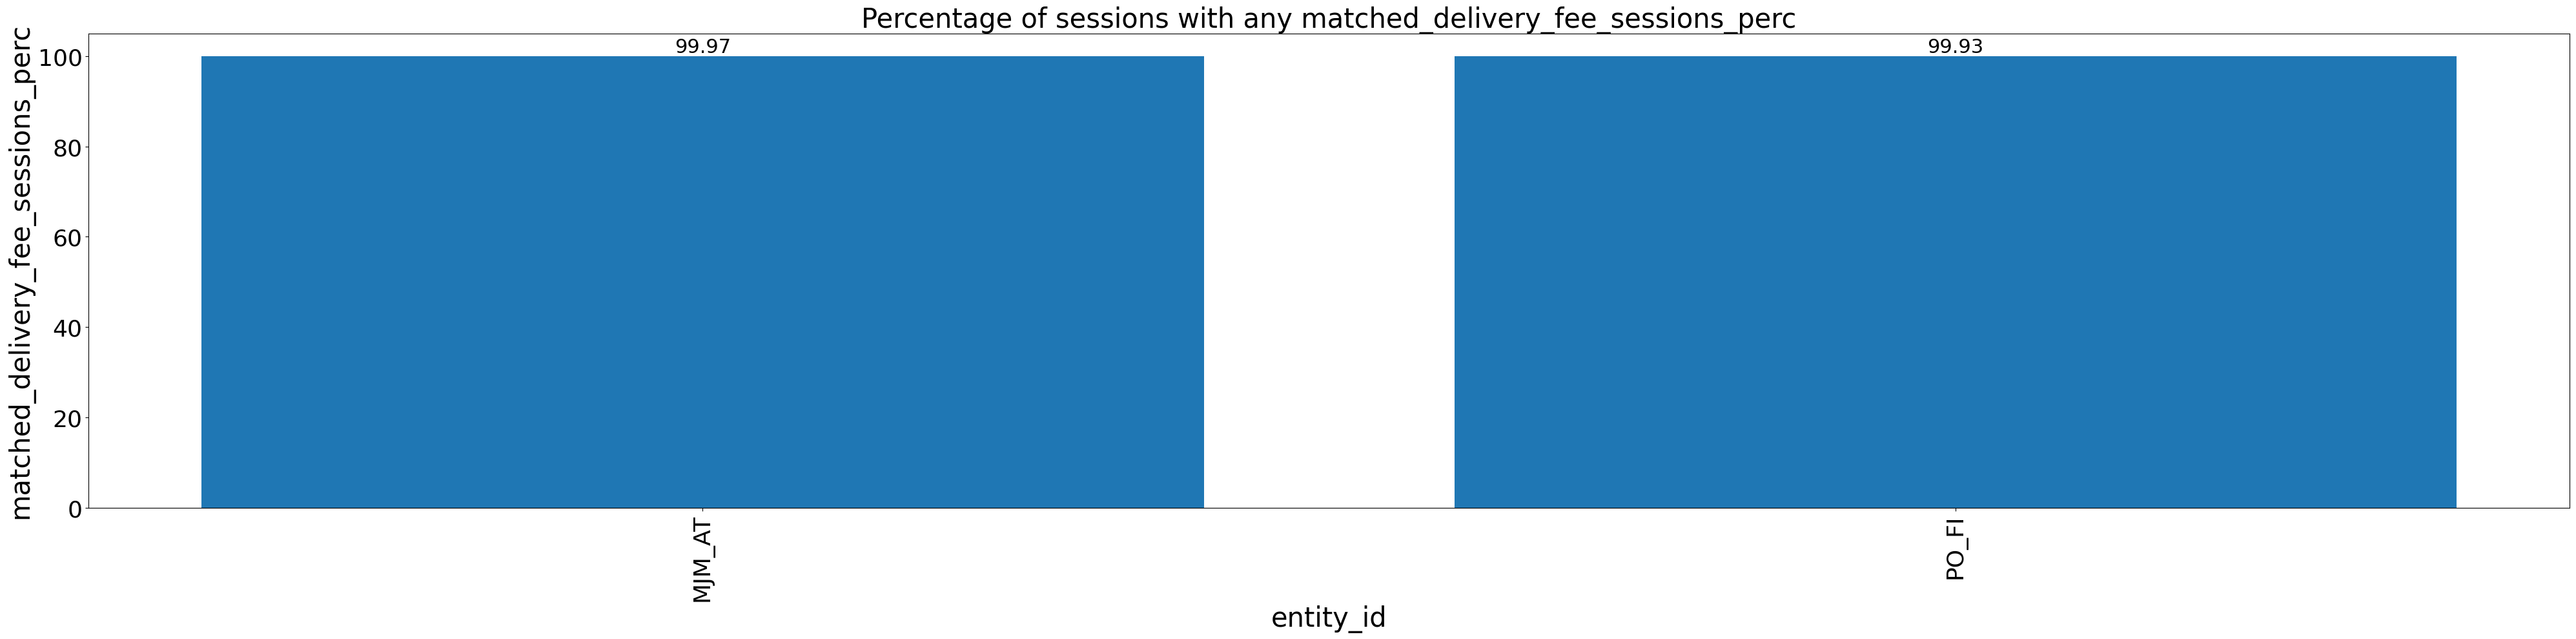

,entity_id,total_sessions,matched_delivery_fee_sessions,unmatched_delivery_fee_sessions,matched_delivery_fee_sessions_perc,unmatched_delivery_fee_sessions_perc
0,MJM_AT,1632860,1632369,491,99.96993,0.03007
1,PO_FI,824152,823546,606,99.92647,0.07353


In [536]:

cols = ['matched_delivery_fee_sessions_perc']

matched_d = dps_impression.sort_values(by = 'entity_id' )

x_axis_column = 'entity_id'

# Extract x-axis data
x_data = dps_impression[x_axis_column]

# Generate a colormap
num_cols = len(cols)
color_map = plt.cm.get_cmap('tab10')  

# Iterate through each column in cols and plot
for i, col in enumerate(cols):
    # Sort data by the current column
    sorted_data = dps_impression.sort_values(by=[col, 'entity_id'] , ascending = False)
    
    # Extract x-axis data
    x_data = sorted_data[x_axis_column]

    # Create a figure and axis for plotting
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 10, forward=True)
    
    # Plot the data with dynamically assigned color
    color = color_map(i / num_cols)  
    bars = ax.bar(x_data, sorted_data[col], color=color)
    
    # Add annotations on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=22)

    ax.set_xlabel(x_axis_column, fontsize=30)
    ax.set_ylabel(col, fontsize=30)
    ax.set_title(f'Percentage of sessions with any {col}', fontsize=30)
    
    plt.xticks(rotation=90, fontsize=26)
    plt.yticks(fontsize=26)
    
    # Show plot
    plt.tight_layout()
    plt.show()

display(dps_impression)

In [537]:

def mapping(start_date, end_date):

    query = """
    with impression_data as (
    select * 
    from (
    SELECT 
            session_key
            ,eventAction
            ,eventTimestamp
            ,event_timestamp_local
            ,TIMESTAMP_TRUNC(event_timestamp_local, SECOND) event_t
            ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
            ,platform AS platform
            ,sessionId AS perseus_session_id
            ,hitMatchId AS perseus_hit_match_id
            ,ROW_NUMBER() OVER (PARTITION BY session_key,shopId ORDER BY event_timestamp_local) row_num
            ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
            ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
            ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
            ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
            ,json_value(eventVariables_json, "$.shopRatingQuality")  AS quality_impressions
            ,json_value(eventVariables_json, "$.businessType")  AS bt_impressions
            ,json_value(eventVariables_json, "$.shopRatingQuantity") AS quantity_impressions
            ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS mov_impressions
            ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS df_impressions 
            ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS dt_impressions
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
    WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
            AND eventAction = 'shop_impressions.loaded'
            AND global_entity_id IN ('MJM_AT','PO_FI')
    ORDER BY eventTimestamp
    )
    where row_num = 1
    ),dps_data as (
    select *
    from 
    (
    SELECT  perseus_session_key
            ,perseus_session_id
            ,dps_session_id
            ,entity_id
            ,row_number() over (partition by perseus_session_key, vendor_code order by event_time) row_num
            ,a.event_time event_time
            ,TIMESTAMP_TRUNC(a.event_time, SECOND) event_t
            ,a.vendor_code
            ,a.vendor_delivery_fee df_dps
            ,a.minimum_order_value mov_dps
            ,a.vendor_delivery_time dt_dps
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` 
    cross join unnest (events) as a
    WHERE created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
    AND perseus_session_key is not null
    AND a.event_action = 'shop_impressions.loaded'
    AND entity_id IN ('MJM_AT','PO_FI')
    ) 
    where row_num = 1
    ), combined as (
    select   coalesce(id.global_entity_id, dpsd.entity_id) entity_id
            ,coalesce(id.session_key,perseus_session_key) session_key
            ,coalesce(id.shopId, dpsd.vendor_code) vendor_code
            ,coalesce(id.perseus_session_id,dpsd.perseus_session_id) perseus_session_id
            ,dpsd.dps_session_id
            ,id.event_t
            ,df_dps 
            ,df_impressions
    from impression_data as id
    left join dps_data as dpsd on dpsd.perseus_session_key = id.session_key and id.global_entity_id = dpsd.entity_id and dpsd.vendor_code = id.shopId
    )
    select  id.entity_id
        , id.session_key
        ,count(*) total_vendors
        ,count(df_dps) non_null_df_dps
        ,count(df_impressions) non_null_df_impressions
        ,count(o.delivery_fee_eur) non_null_df_orders
        ,count (case when (df_dps = df_impressions) then vendor_code end) as delivery_fee_match
        ,count (case when (CAST(REGEXP_EXTRACT(df_dps, r'\d+') as numeric) = o.delivery_fee_eur) then vendor_code end) as dps_orders_df_match
        ,count (case when (CAST(REGEXP_EXTRACT(df_impressions, r'\d+') as numeric) = o.delivery_fee_eur) then vendor_code end) as impressions_orders_df_match
    from combined id
    left join `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o on o.dps_session_id = id.dps_session_id and o.vendor_id = id.vendor_code and o.entity_id IN ('MJM_AT','PO_FI') and cast (o.dps_session_timestamp as date) BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
    group by 1,2

    """

    return query


<>:52: SyntaxWarning: invalid escape sequence '\d'
<>:52: SyntaxWarning: invalid escape sequence '\d'
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19277/2416045607.py:52: SyntaxWarning: invalid escape sequence '\d'
  WHERE created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"


In [299]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-30'

session_data = client.query(mapping(start_date, end_date)).to_dataframe()


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [300]:
session_data['non_null_df_orders'].sum()

np.int64(0)

In [221]:
def impressions_completeness(start_date, end_date):

    impression_completeness = """
            with impression_data as (
            SELECT 
                session_key
                ,event_id
                ,eventAction
                ,eventTimestamp
                ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,hitMatchId AS perseus_hit_match_id
                ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
                ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
                ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
                ,json_value(eventVariables_json, "$.shopRatingQuality")  AS shopRatingQuality
                ,json_value(eventVariables_json, "$.businessType")  AS businessType
                ,json_value(eventVariables_json, "$.shopRatingQuantity") AS shopRatingQuantity
                ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS shopMinimumOrderValue
                ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS vendor_delivery_fee
                ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS shopDeliveryTime
            FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
            WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND global_entity_id in ('MJM_AT','PO_FI')
            ),
            aggregation as (
            SELECT 
            global_entity_id
            ,count(distinct perseus_session_id) as total_sessions
            ,count(distinct perseus_hit_match_id) as total_hits
            ,count(distinct event_id) as total_events
            ,count(*) as total_rows
            ,count(distinct case when eventTimestamp is not null then event_id end) as eventTimestamp_hits
            ,count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then event_id end) as fee_hits
            ,count(distinct case when shopRatingQuality is not null then event_id end) as quality_hits
            ,count(distinct case when shopRatingQuantity is not null then event_id end) as quantity_hits
            ,count(distinct case when cast(regexp_extract(shopMinimumOrderValue,r'(\d[\d.]*)') as numeric) is not null then event_id end) as mov_hits
            ,count(distinct case when shopDeliveryTime is not null then event_id end) as delivery_time_hits
            ,count(distinct case when businessType is not null then event_id end) as business_type_hits
            FROM impression_data
            GROUP BY 1
            )
            select a.*,
                1.00 * (fee_hits / total_events) fee_completeness
                ,1.00 * (eventTimestamp_hits / total_events) eventTimestamp_completeness
                ,1.00 * (quality_hits / total_events) quality_completeness
                ,1.00 * (quantity_hits / total_events ) quantity_completeness
                ,1.00 * (mov_hits / total_events ) mov_completeness
                ,1.00 * (delivery_time_hits / total_events ) deliverytime_completeness
                ,1.00 * (business_type_hits / total_events ) bussinesstype_completeness
            from aggregation a
            """

    return impression_completeness


def session_completeness(start_date, end_date):

    session_completeness = """
            with impression_data as (
            SELECT 
                session_key
                ,event_id
                ,eventAction
                ,eventTimestamp
                ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,hitMatchId AS perseus_hit_match_id
                ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
                ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
                ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
                ,json_value(eventVariables_json, "$.shopRatingQuality")  AS shopRatingQuality
                ,json_value(eventVariables_json, "$.businessType")  AS businessType
                ,json_value(eventVariables_json, "$.shopRatingQuantity") AS shopRatingQuantity
                ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS shopMinimumOrderValue
                ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS vendor_delivery_fee
                ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS shopDeliveryTime
            FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
            WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND global_entity_id in ('MJM_AT','PO_FI')
            ),
            aggregation as (
            SELECT 
                global_entity_id
                ,session_key
                ,count(distinct case when eventTimestamp is not null then event_id end) as eventTimestamp_hits
                ,count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then event_id end) as fee_hits
                ,count(distinct case when shopRatingQuality is not null then event_id end) as quality_hits
                ,count(distinct case when shopRatingQuantity is not null then event_id end) as quantity_hits
                ,count(distinct case when cast(regexp_extract(shopMinimumOrderValue,r'(\d[\d.]*)') as numeric) is not null then event_id end) as mov_hits
                ,count(distinct case when shopDeliveryTime is not null then event_id end) as delivery_time_hits
                ,count(distinct case when businessType is not null then event_id end) as business_type_hits
            FROM impression_data
            GROUP BY 1, 2
            )
            select global_entity_id
                   ,count (session_key) total_sessions
                   ,sum( case when fee_hits > 0 then 1 else 0 end ) sessions_non_null
                   ,sum( case when eventTimestamp_hits > 0 then 1 else 0 end ) eventTimestamp_non_null
                   ,sum( case when quality_hits > 0 then 1 else 0 end ) quality_non_null
                   ,sum( case when quantity_hits > 0 then 1 else 0 end ) quantity_non_null
                   ,sum( case when mov_hits > 0 then 1 else 0 end ) mov_non_null
                   ,sum( case when delivery_time_hits > 0 then 1 else 0 end ) delivery_time_non_null
                   ,sum( case when business_type_hits > 0 then 1 else 0 end ) bussiness_type_non_null
                   ,1.00 * (sum( case when fee_hits > 0 then 1 else 0 end ) / count ( session_key))  session_with_fee_info
                   ,1.00 * (sum( case when eventTimestamp_hits > 0 then 1 else 0 end ) / count ( session_key))  session_with_eventTimestamp_info
                   ,1.00 * (sum( case when quality_hits > 0 then 1 else 0 end ) / count ( session_key))  session_with_quality_info
                   ,1.00 * (sum( case when quantity_hits > 0 then 1 else 0 end ) / count ( session_key)) session_with_quantity_info
                   ,1.00 * (sum( case when mov_hits > 0 then 1 else 0 end ) / count ( session_key))  session_with_mov_info
                   ,1.00 * (sum( case when delivery_time_hits > 0 then 1 else 0 end ) / count ( session_key))  session_with_delivery_time_info
                   ,1.00 * (sum( case when business_type_hits > 0 then 1 else 0 end ) / count ( session_key))  session_with_business_type_info
            from aggregation a
            group by 1
            """

    return session_completeness



<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:84: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:84: SyntaxWarning: invalid escape sequence '\d'
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19277/370468488.py:25: SyntaxWarning: invalid escape sequence '\d'
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19277/370468488.py:84: SyntaxWarning: invalid escape sequence '\d'
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19277/1511420942.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cm

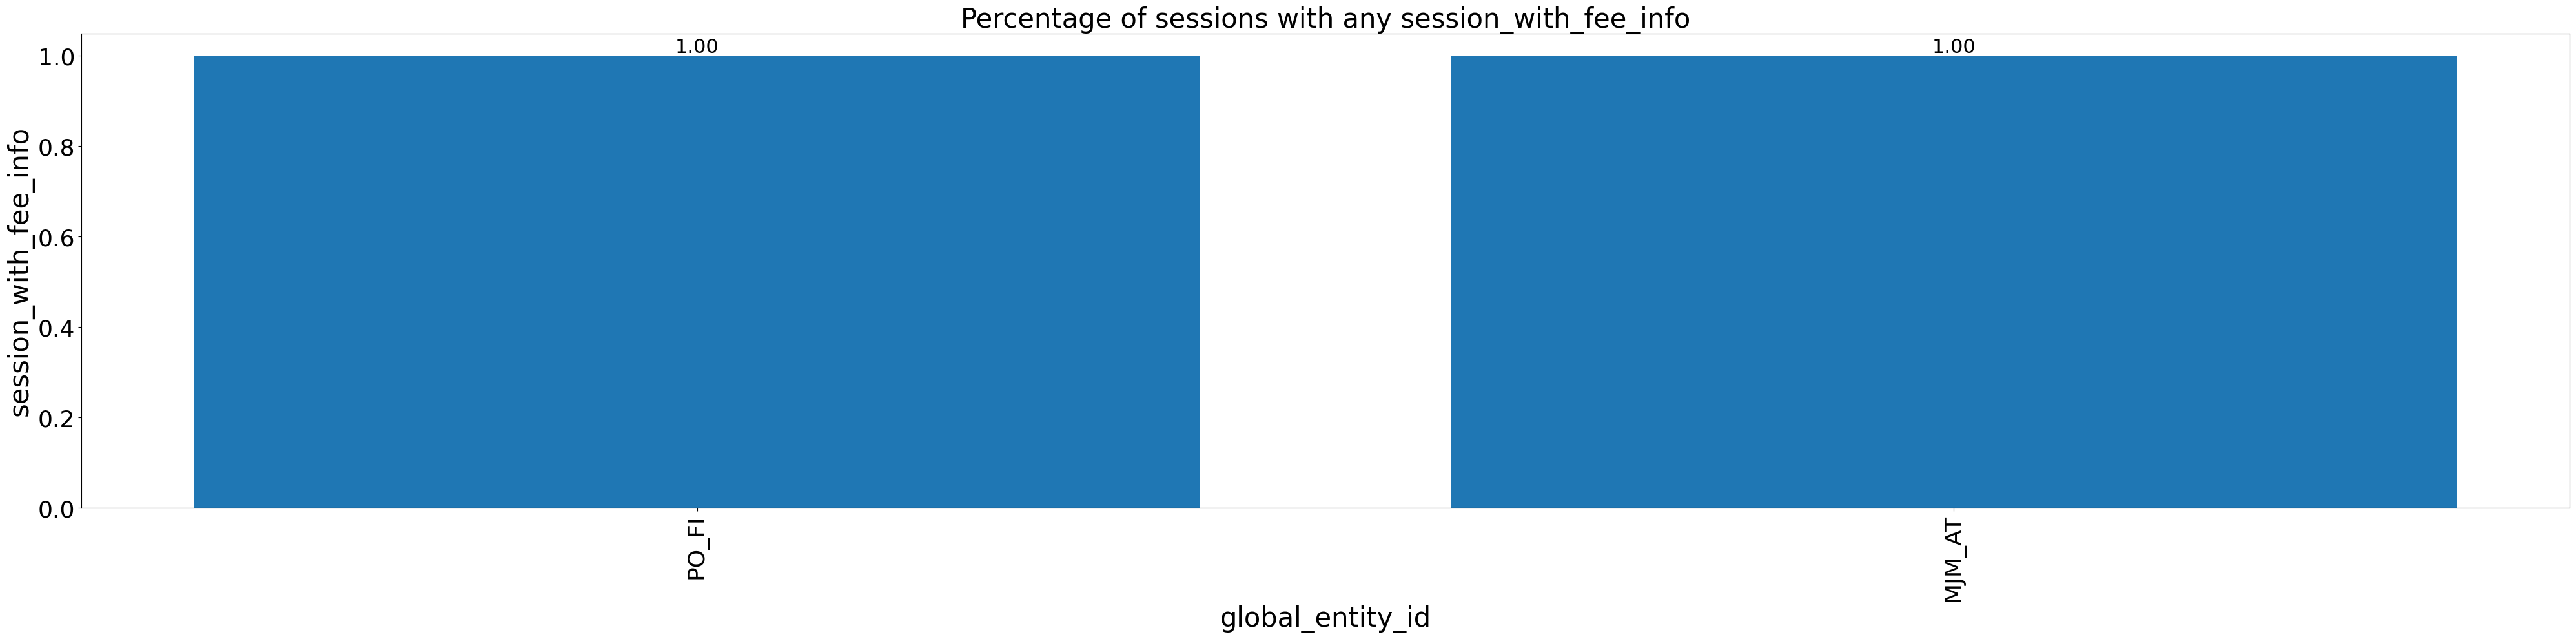

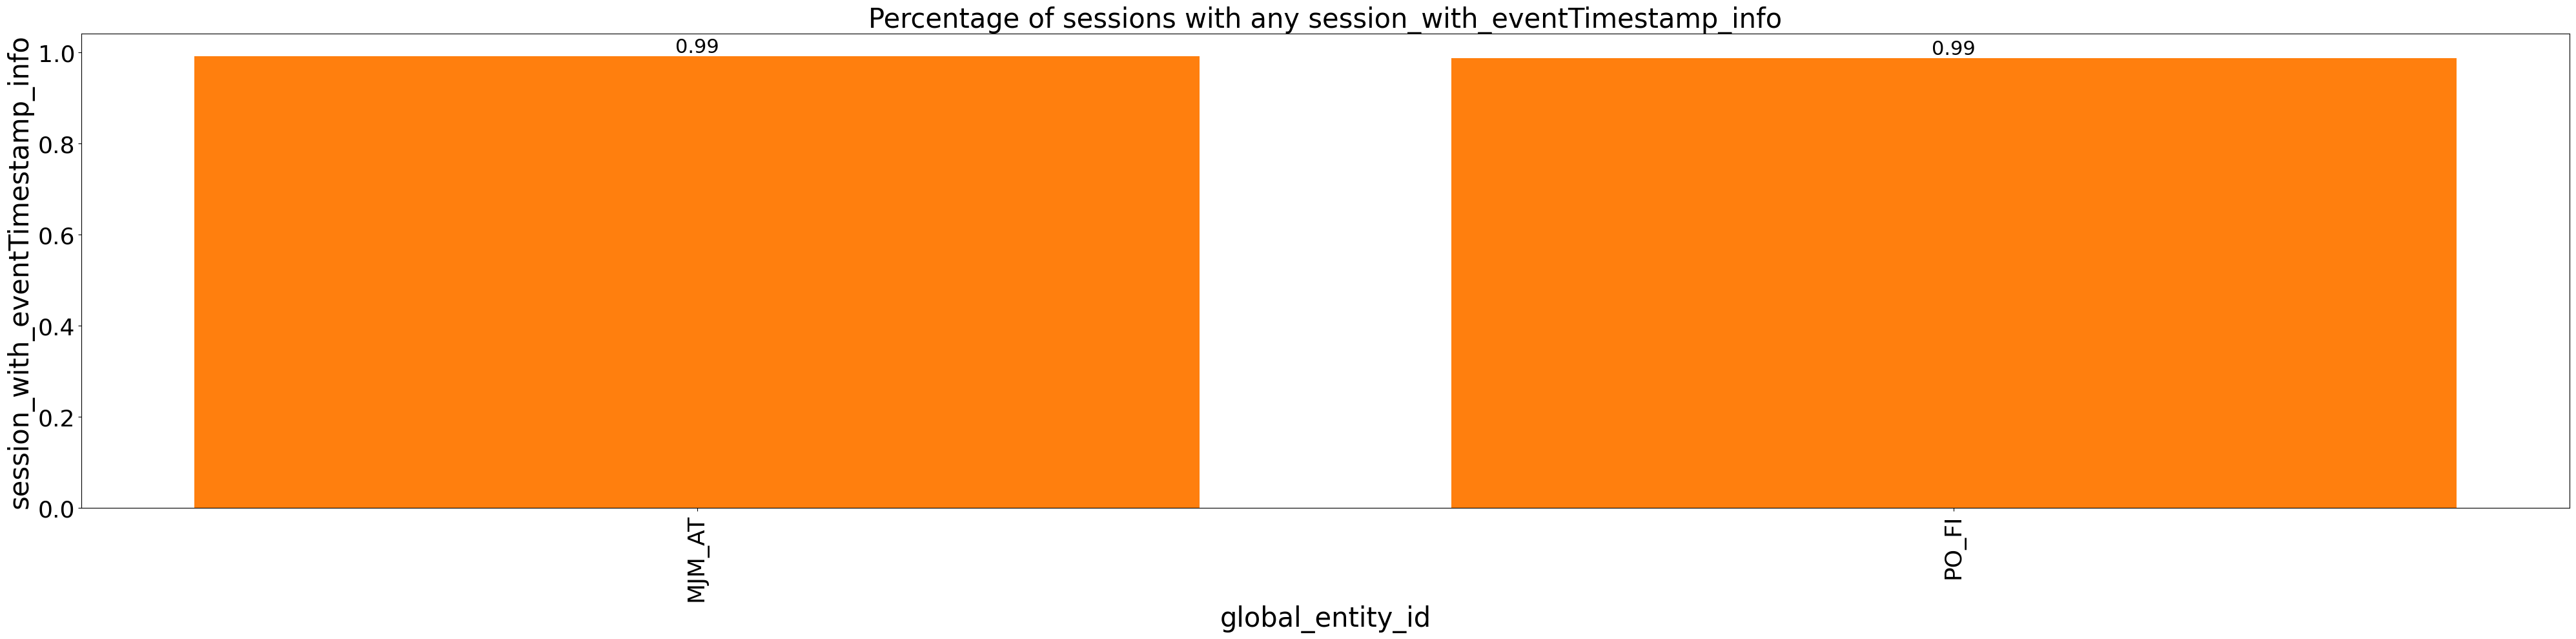

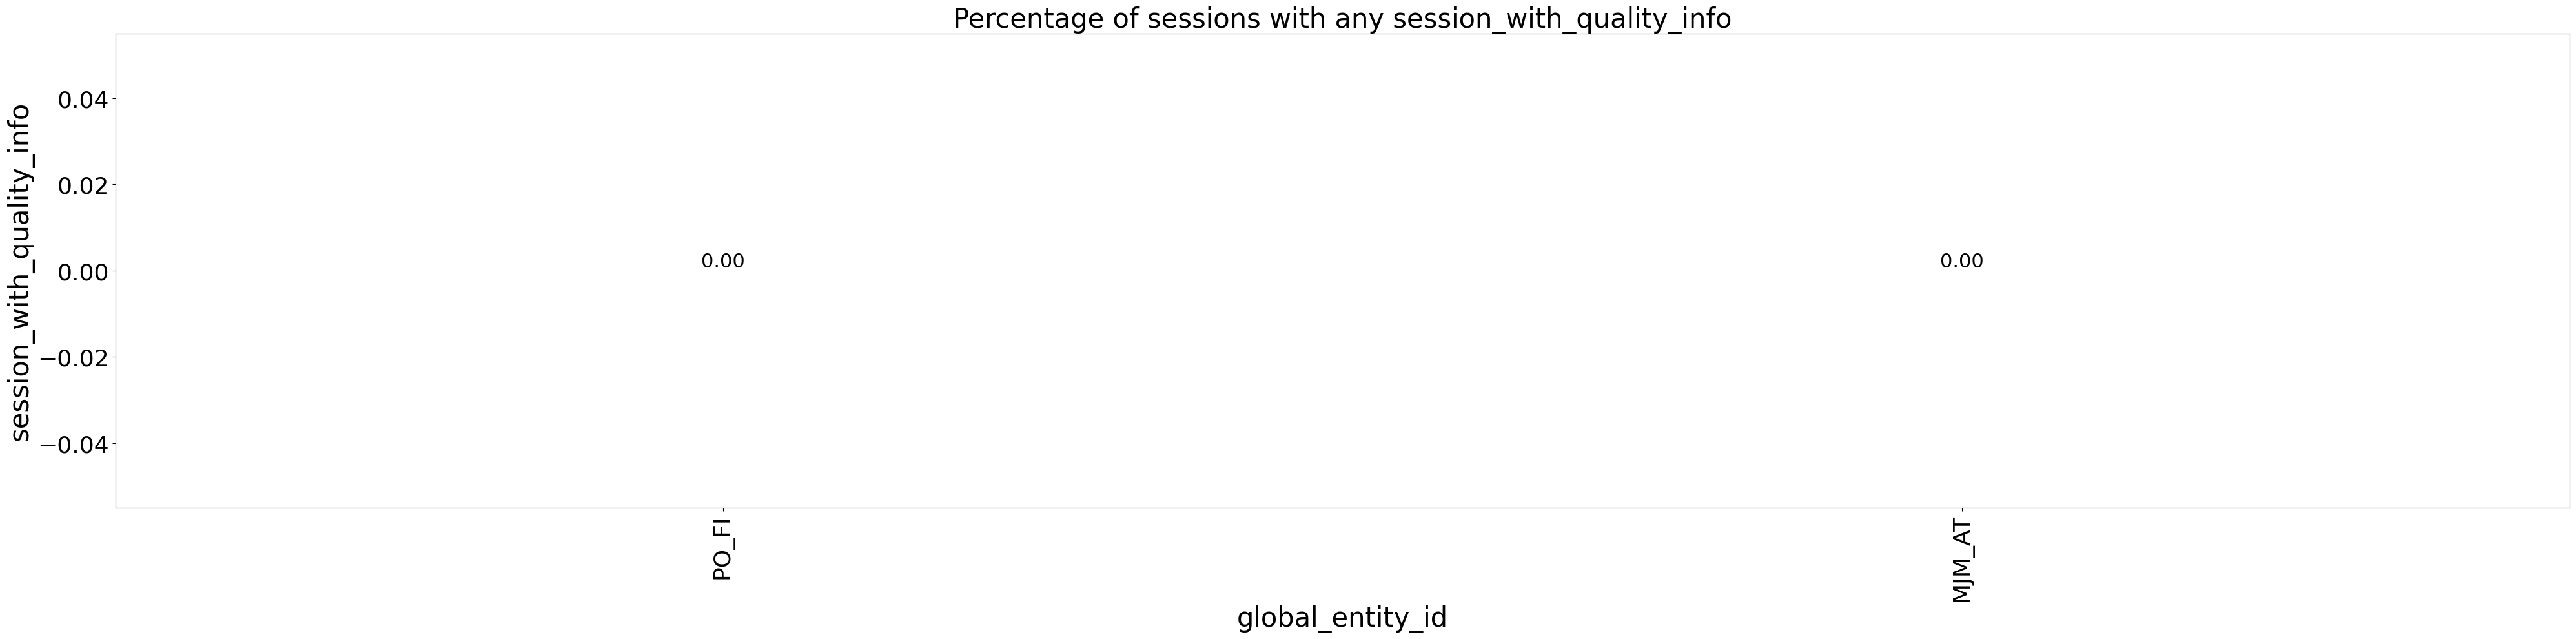

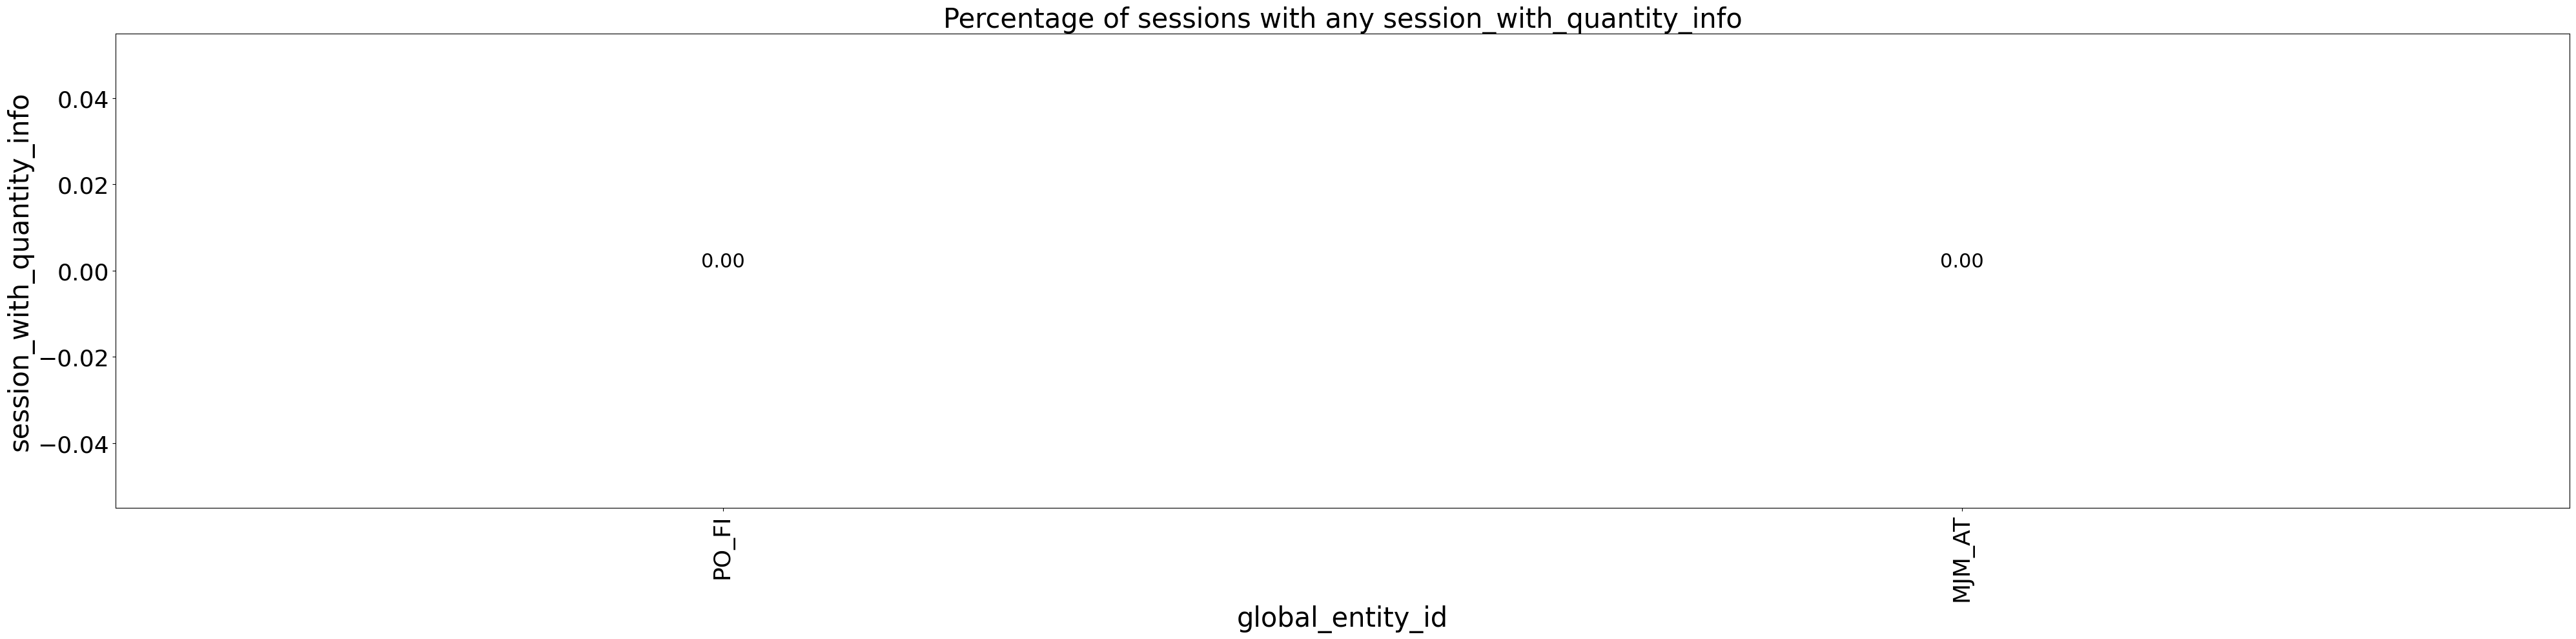

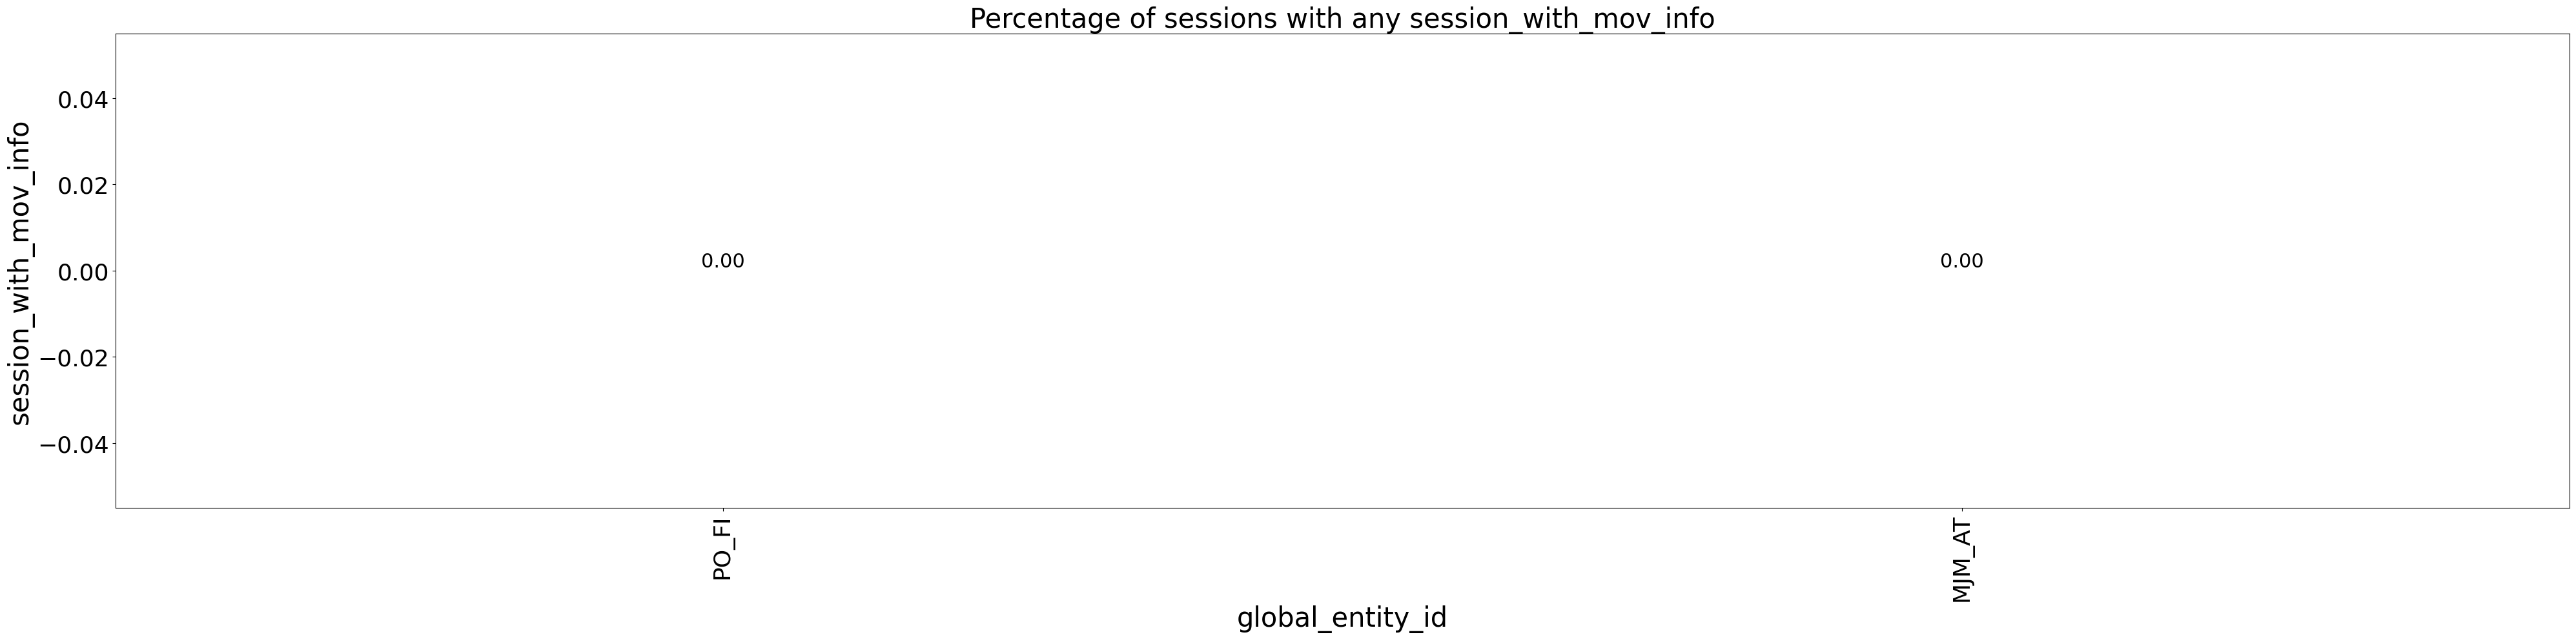

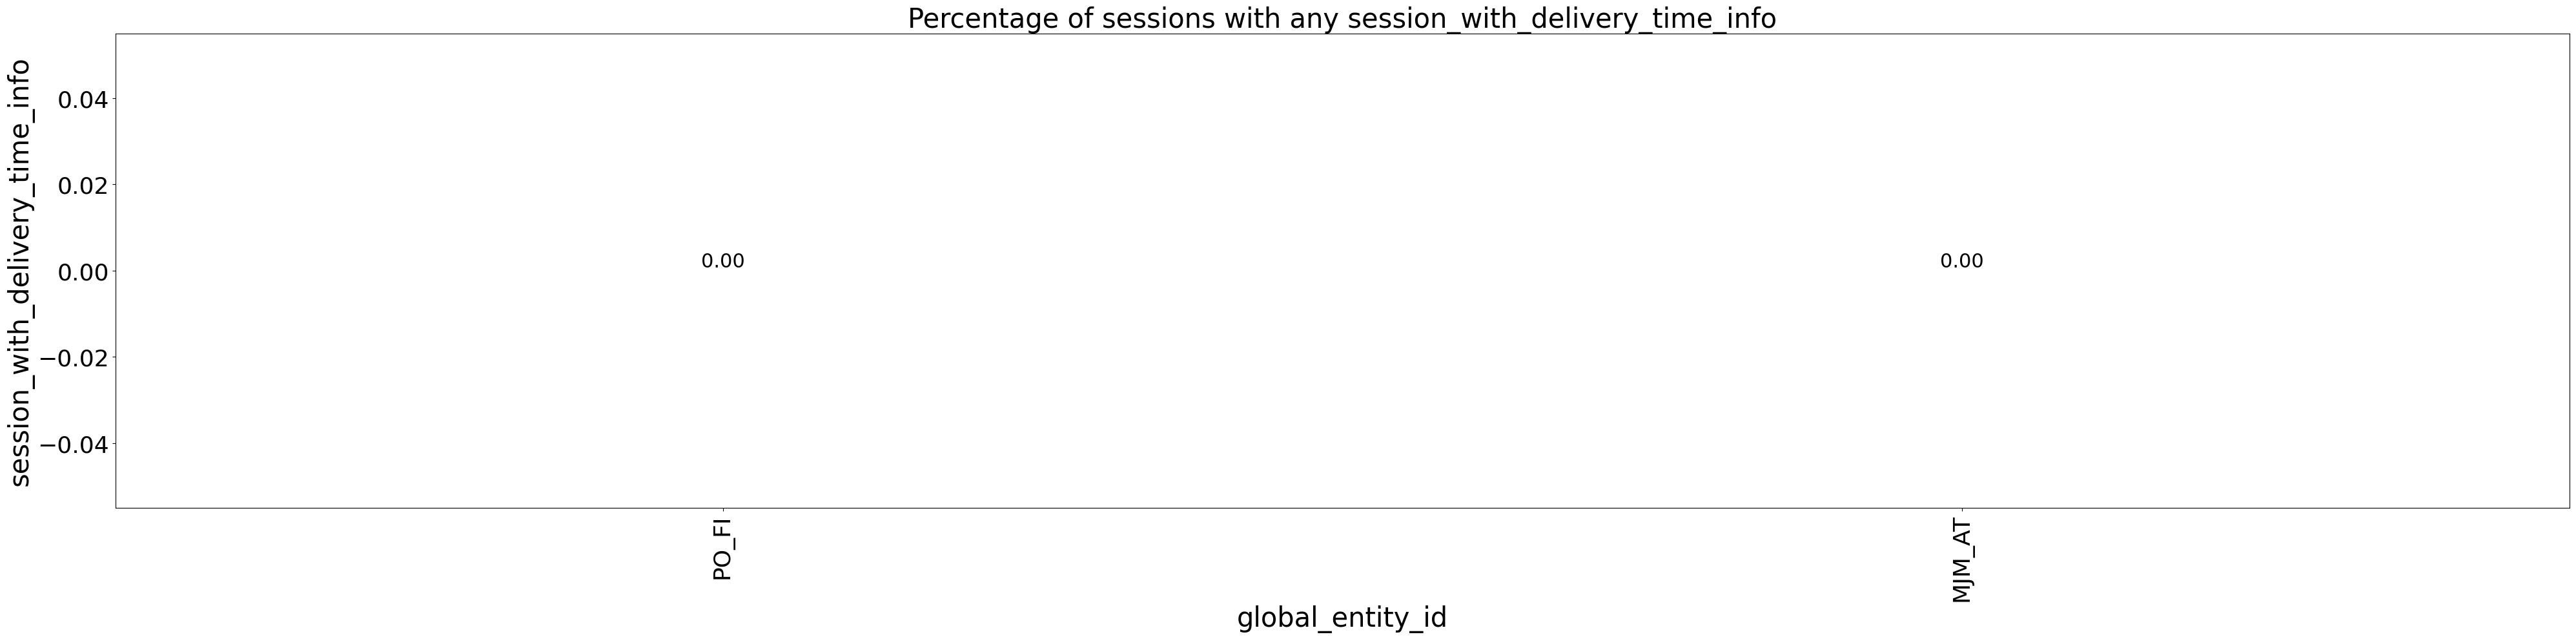

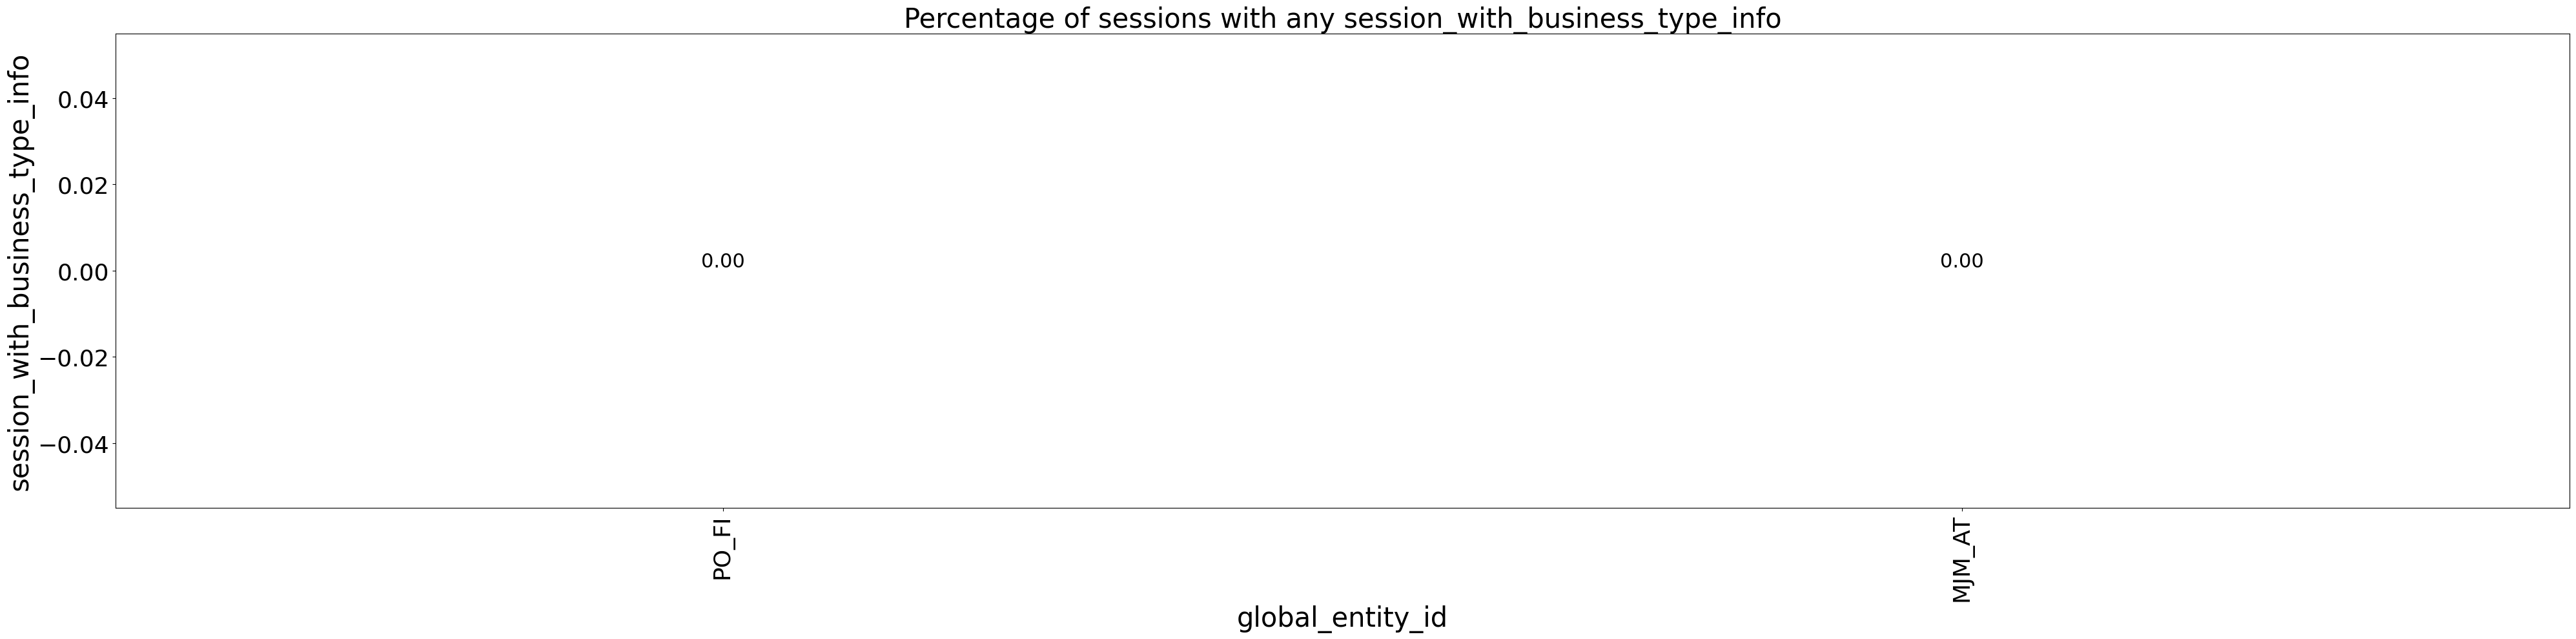

In [222]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-30'
# start_date_dps = '2024-05-31'
# end_date_dps = '2024-06-01'

# List of entity IDs
entity_ids = [
   "'MJM_AT'","'PO_FI'"
]

session_data = client.query(session_completeness(start_date, end_date)).to_dataframe()

session_data_completeness = session_data.copy()
session_data_completeness['entity_grouping'] = session_data_completeness['global_entity_id'].str.split('_').str[0]
session_data_completeness = session_data_completeness.dropna(subset=['global_entity_id'])

cols = [col for col in session_data_completeness.columns if '_info' in col]

session_data_completeness = session_data_completeness.sort_values(by = 'entity_grouping' )

x_axis_column = 'global_entity_id'

# Extract x-axis data
x_data = session_data_completeness[x_axis_column]

# Generate a colormap
num_cols = len(cols)
color_map = plt.cm.get_cmap('tab10')  

# Iterate through each column in cols and plot
for i, col in enumerate(cols):
    # Sort data by the current column
    sorted_data = session_data_completeness.sort_values(by=[col, 'global_entity_id'] , ascending = False)
    
    # Extract x-axis data
    x_data = sorted_data[x_axis_column]

    # Create a figure and axis for plotting
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 10, forward=True)
    
    # Plot the data with dynamically assigned color
    color = color_map(i / num_cols)  
    bars = ax.bar(x_data, sorted_data[col], color=color)
    
    # Add annotations on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=22)

    ax.set_xlabel(x_axis_column, fontsize=30)
    ax.set_ylabel(col, fontsize=30)
    ax.set_title(f'Percentage of sessions with any {col}', fontsize=30)
    
    plt.xticks(rotation=90, fontsize=26)
    plt.yticks(fontsize=26)
    
    # Show plot
    plt.tight_layout()
    plt.show()


In [223]:
session_data_completeness

,global_entity_id,total_sessions,sessions_non_null,eventTimestamp_non_null,quality_non_null,quantity_non_null,mov_non_null,delivery_time_non_null,bussiness_type_non_null,session_with_fee_info,session_with_eventTimestamp_info,session_with_quality_info,session_with_quantity_info,session_with_mov_info,session_with_delivery_time_info,session_with_business_type_info,entity_grouping
1,MJM_AT,1632860,1631736,1618856,0,0,0,0,0,0.999312,0.991424,0.0,0.0,0.0,0.0,0.0,MJM
0,PO_FI,824152,823625,813273,0,0,0,0,0,0.999361,0.986800,0.0,0.0,0.0,0.0,0.0,PO


In [224]:
relevant = ['entity_grouping','global_entity_id']
complete = []

for col in session_data_completeness.columns:
    if "_info" in col:
        relevant.append(col)
        complete.append(col)

session_completeness_table = session_data_completeness[relevant]

session_completeness_table[complete] = round(session_completeness_table[complete] * 100,0)

display(session_completeness_table)


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19277/4018092358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_completeness_table[complete] = round(session_completeness_table[complete] * 100,0)


,entity_grouping,global_entity_id,session_with_fee_info,session_with_eventTimestamp_info,session_with_quality_info,session_with_quantity_info,session_with_mov_info,session_with_delivery_time_info,session_with_business_type_info
1,MJM,MJM_AT,100.0,99.0,0.0,0.0,0.0,0.0,0.0
0,PO,PO_FI,100.0,99.0,0.0,0.0,0.0,0.0,0.0


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19277/3541393433.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cm

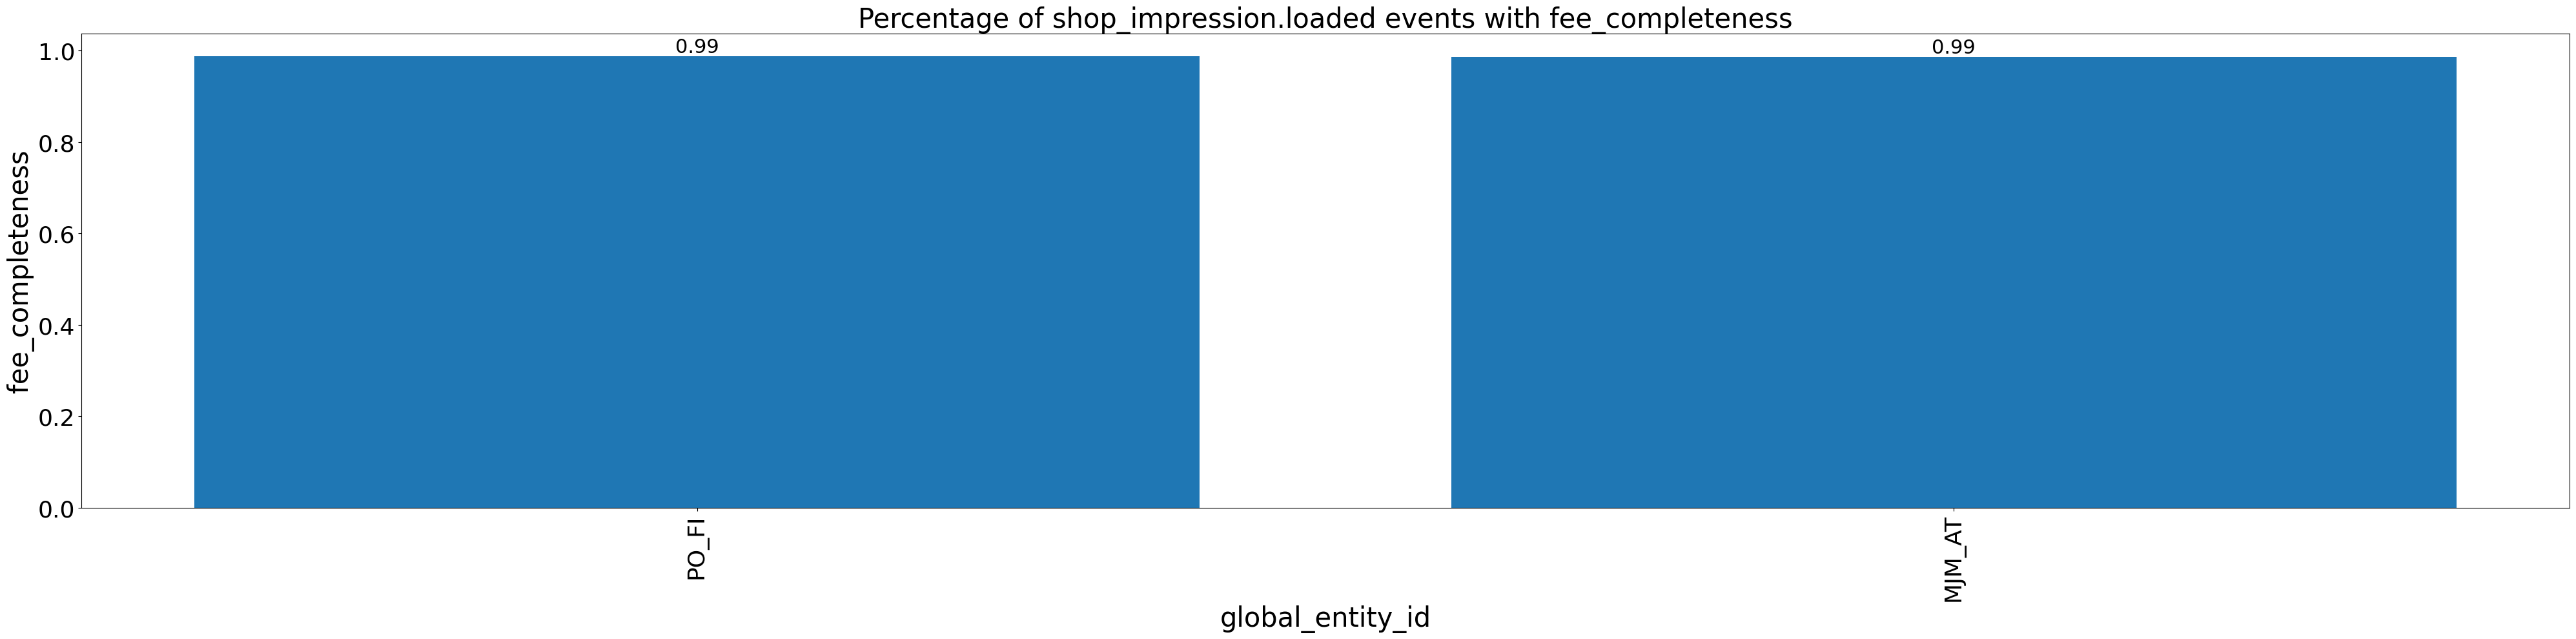

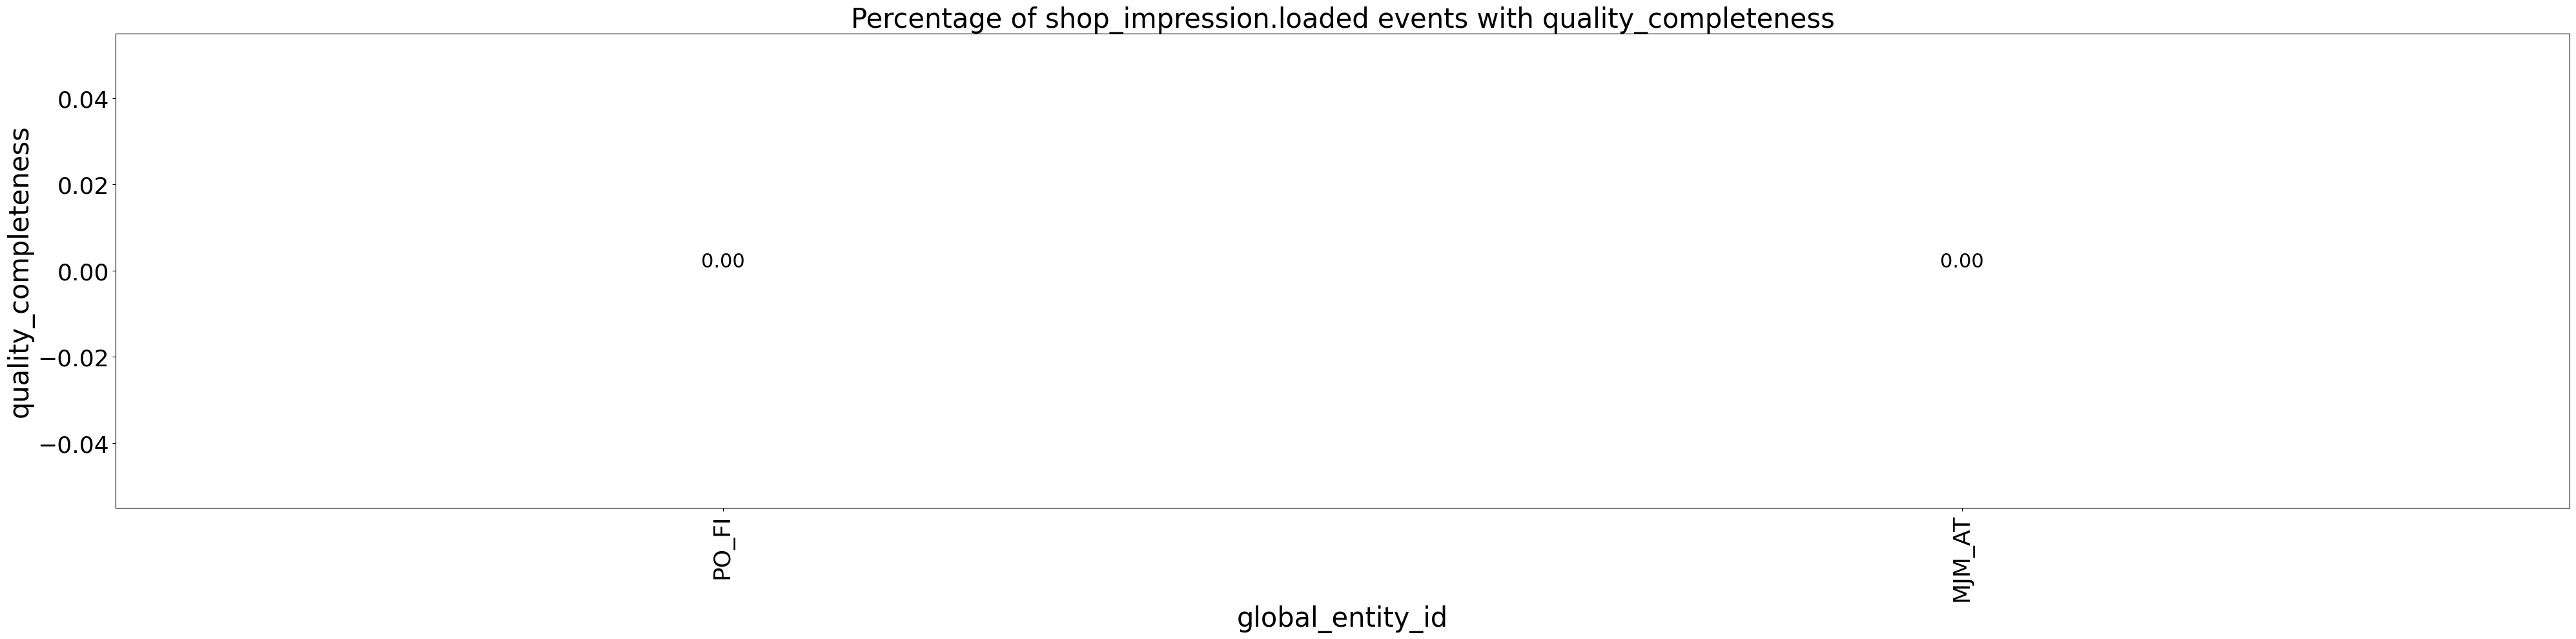

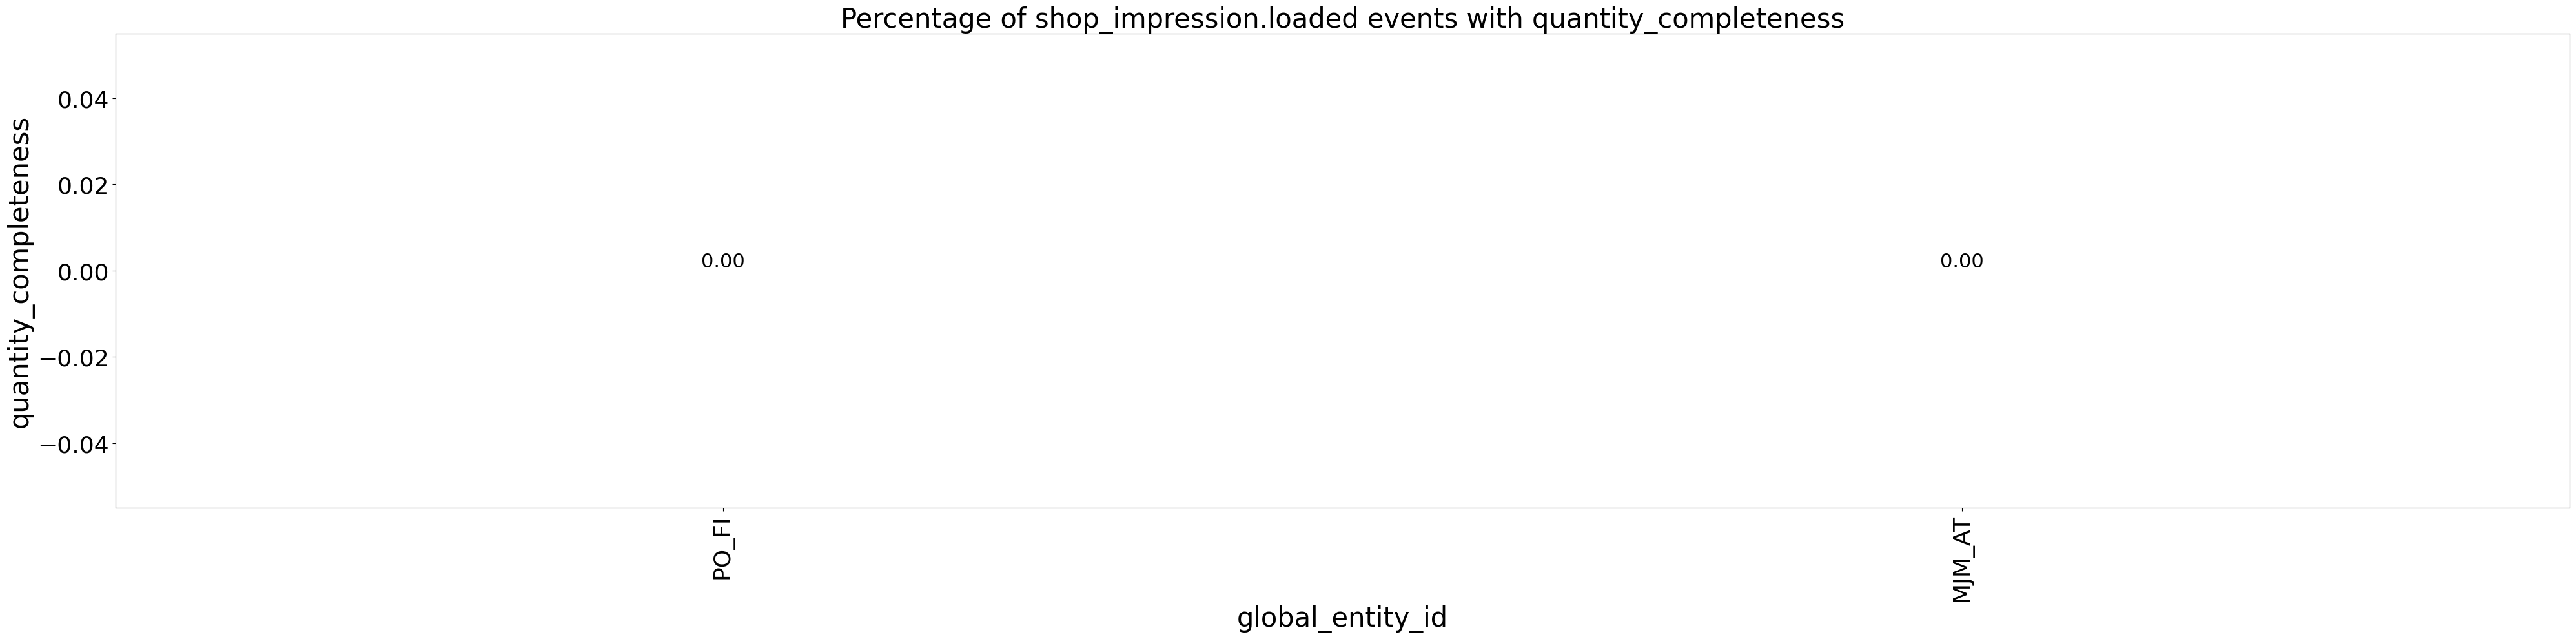

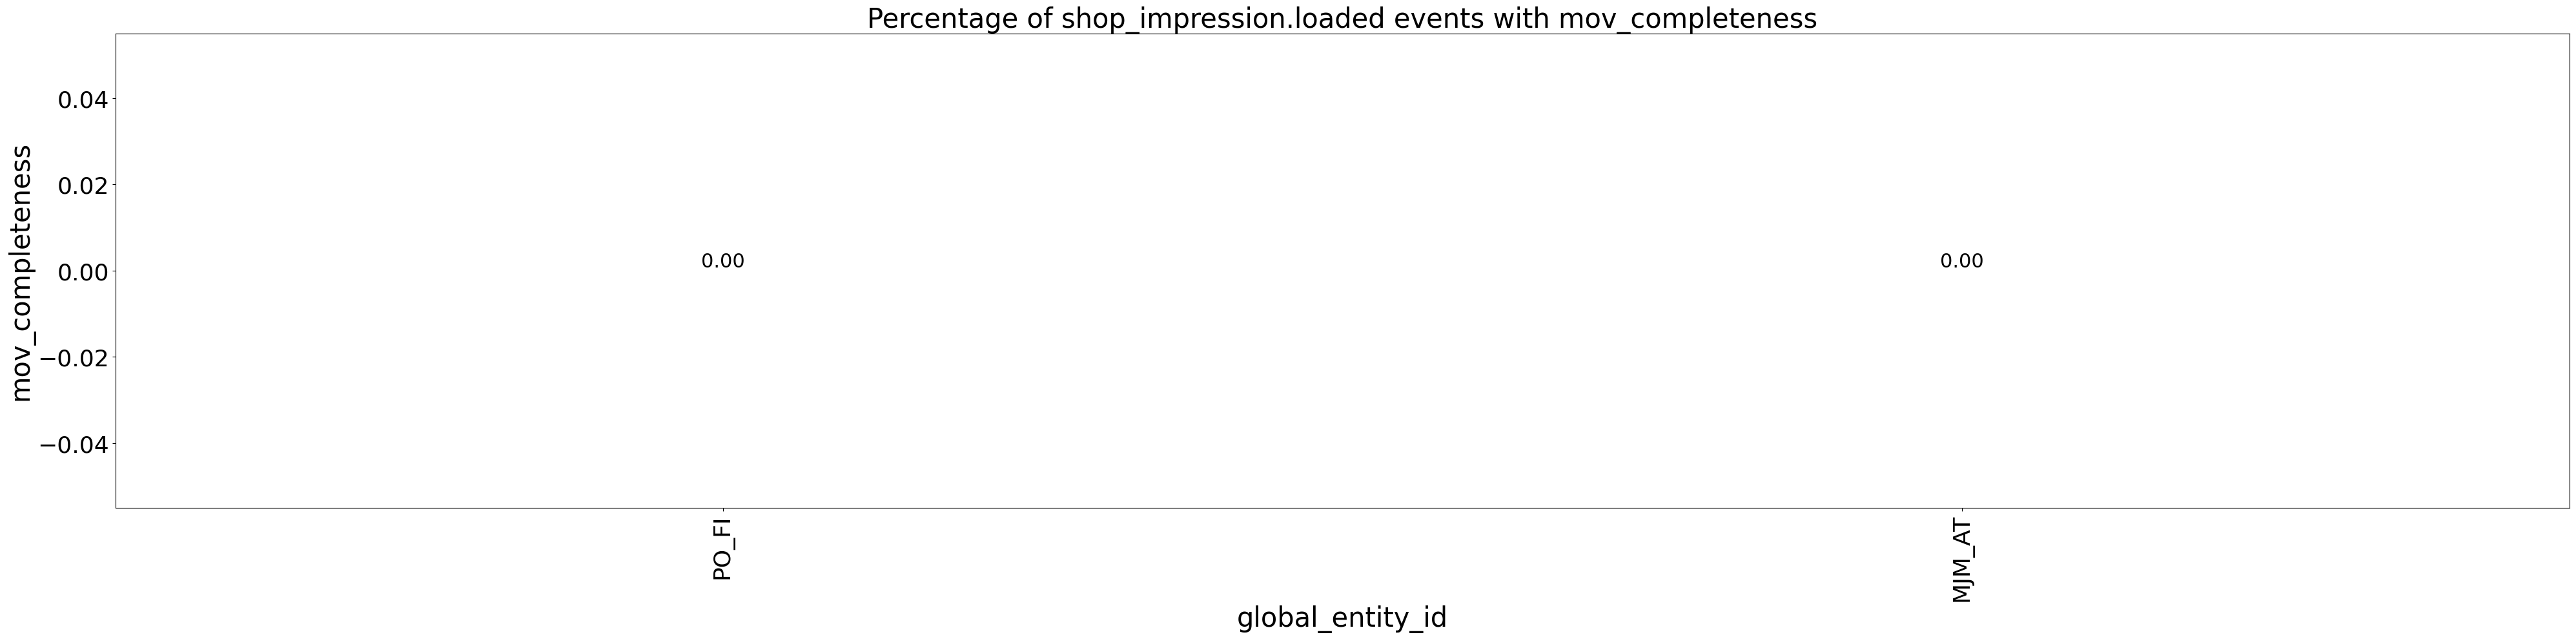

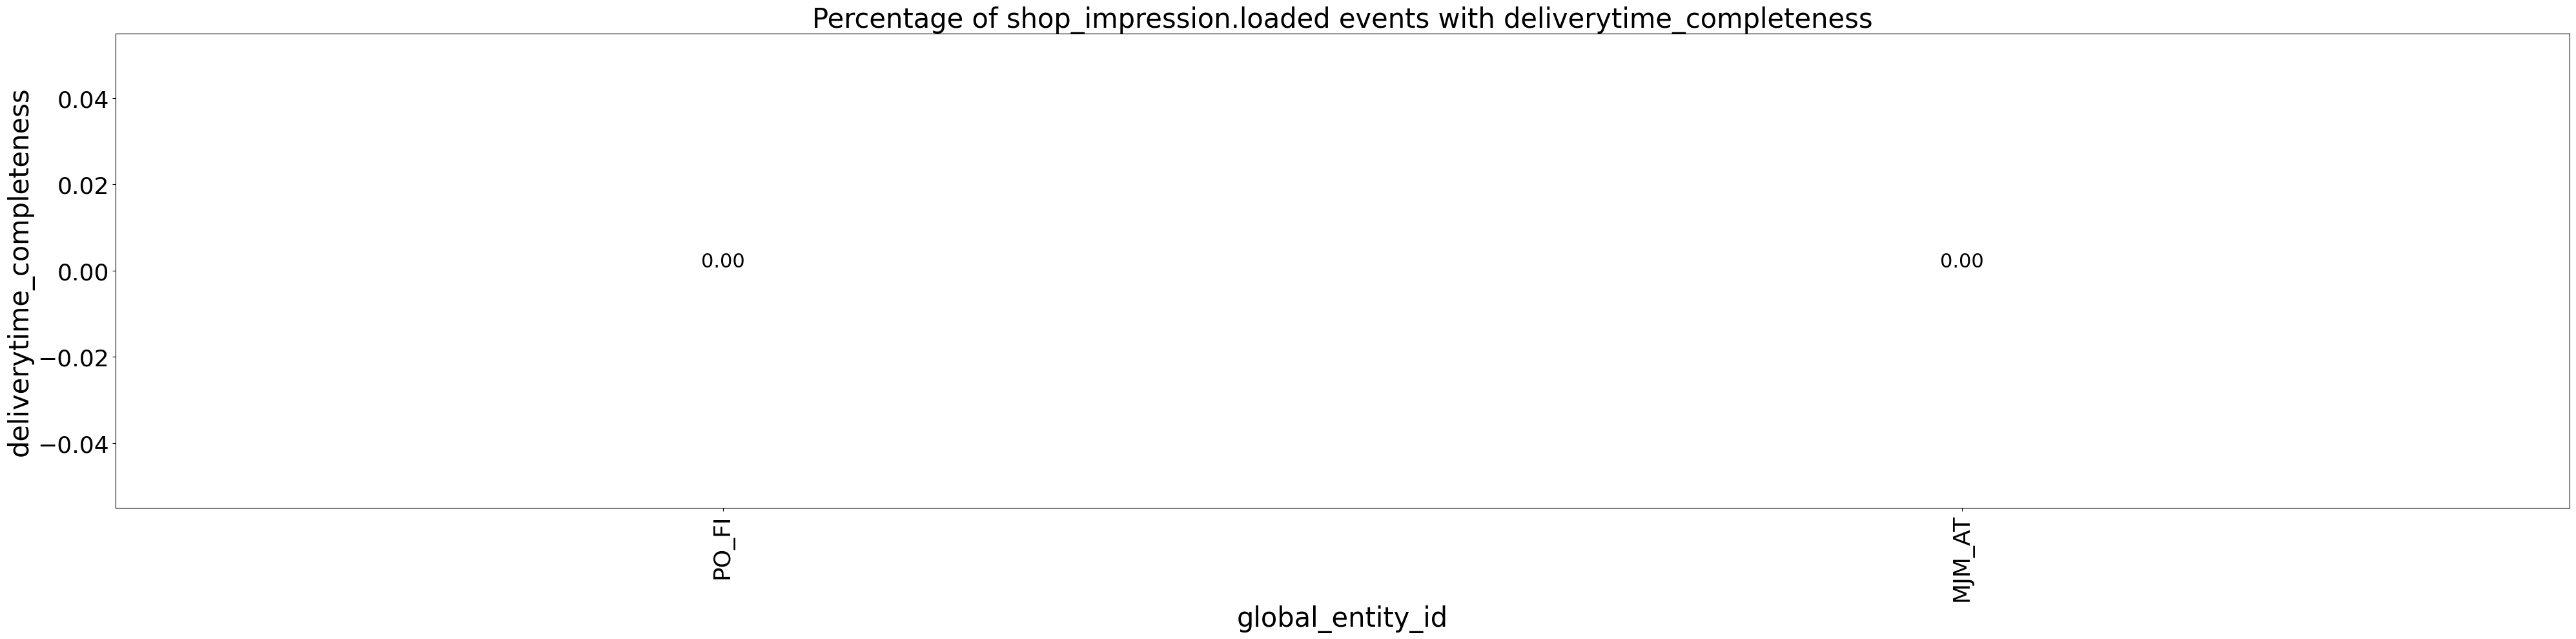

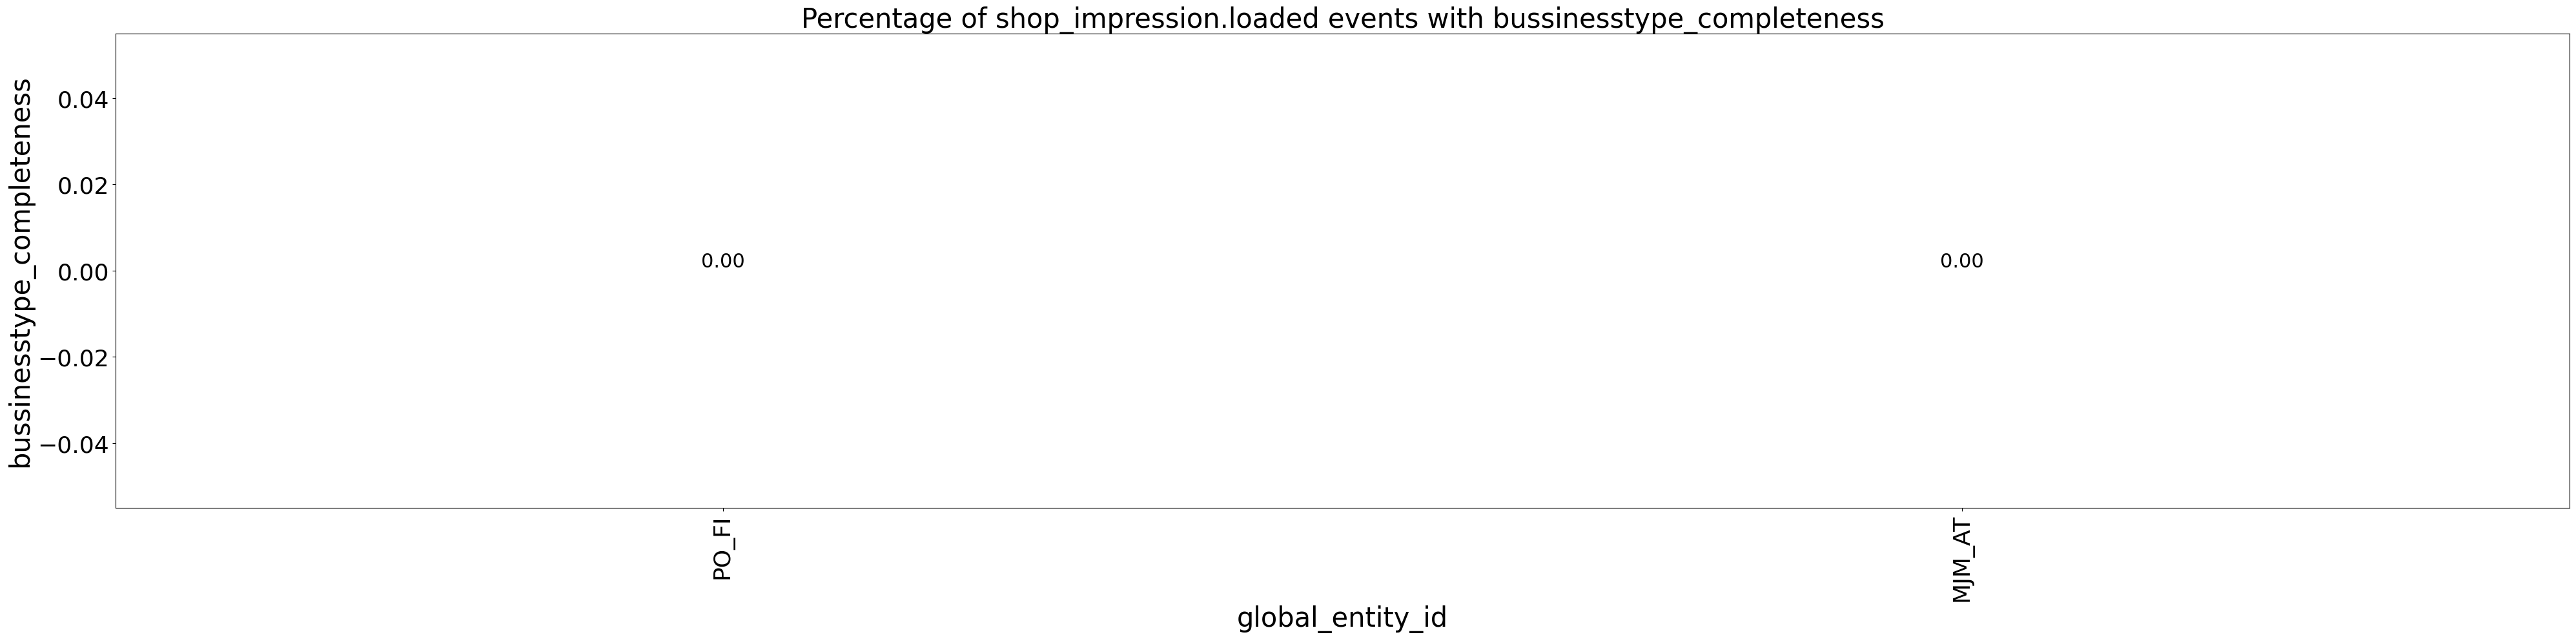

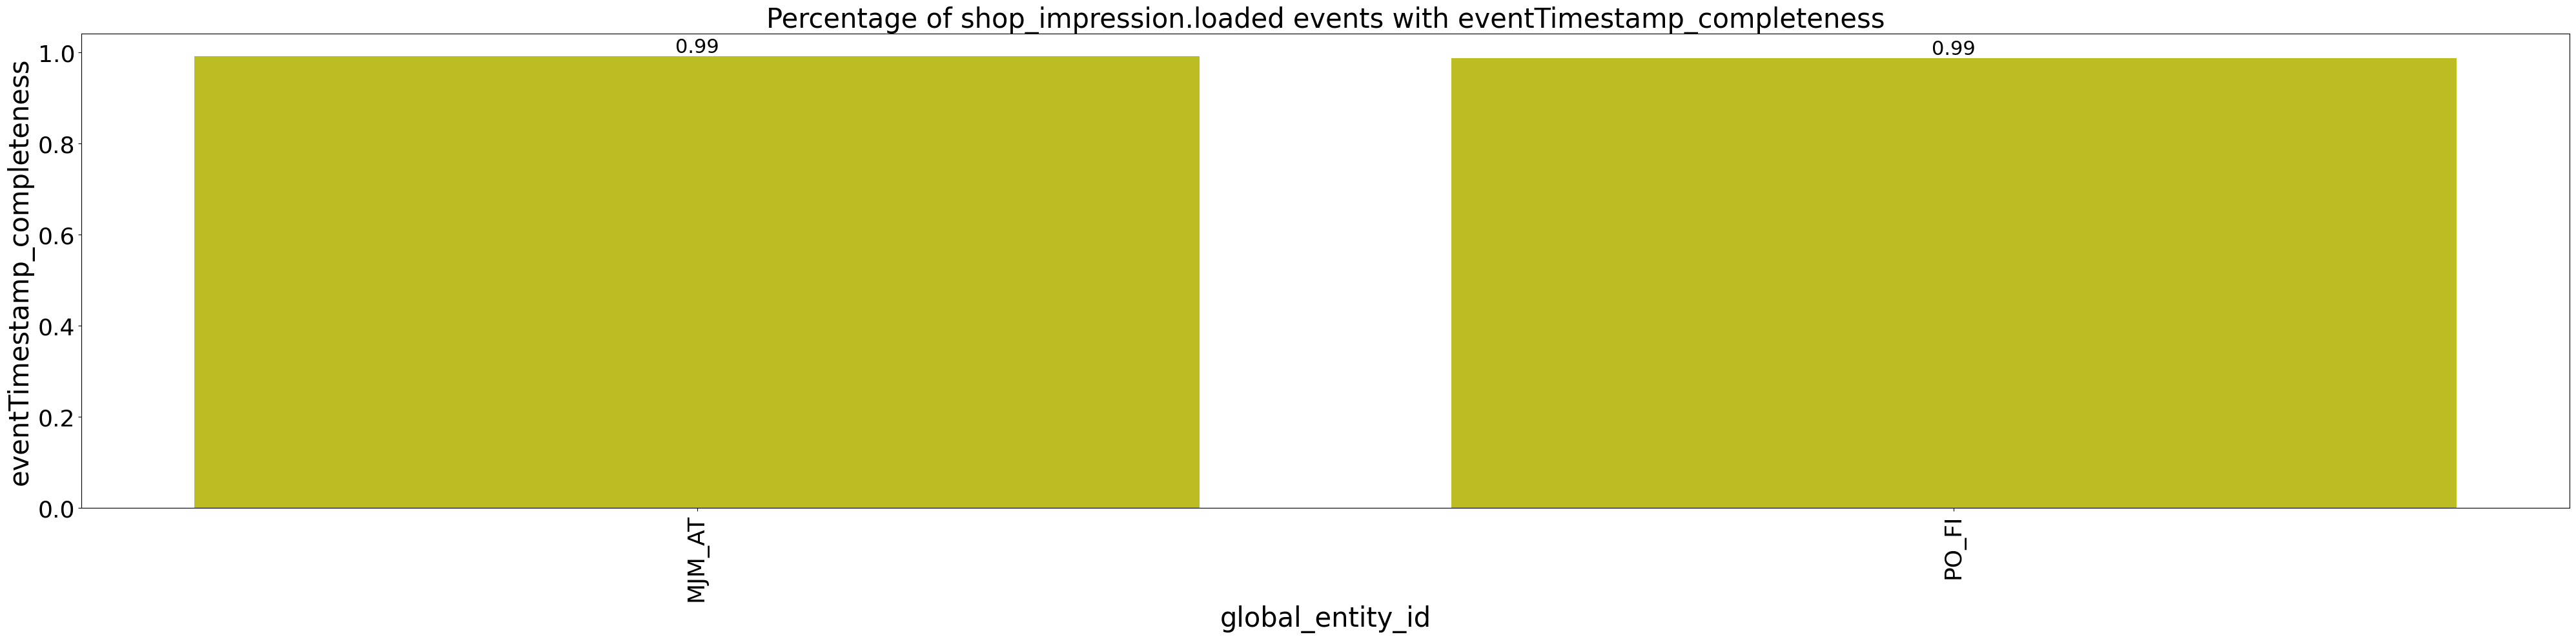

In [226]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-30'
# start_date_dps = '2024-05-31'
# end_date_dps = '2024-06-01'


impression_data = client.query(impressions_completeness(start_date, end_date)).to_dataframe()

impression_data_completeness = impression_data.copy()
impression_data_completeness['entity_grouping'] = impression_data_completeness['global_entity_id'].str.split('_').str[0]
impression_data_completeness = impression_data_completeness.dropna(subset=['global_entity_id'])

cols = ['fee_completeness', 'quality_completeness', 'quantity_completeness', 
        'mov_completeness', 'deliverytime_completeness', 'bussinesstype_completeness', 'eventTimestamp_completeness']

impression_data_completeness = impression_data_completeness.sort_values(by = 'entity_grouping', )

x_axis_column = 'global_entity_id'

# Extract x-axis data
x_data = impression_data_completeness[x_axis_column]

# Generate a colormap
num_cols = len(cols)
color_map = plt.cm.get_cmap('tab10')  

# Iterate through each column in cols and plot
for i, col in enumerate(cols):
    # Sort data by the current column
    sorted_data = impression_data_completeness.sort_values(by=[col, 'global_entity_id'] , ascending = False)
    
    # Extract x-axis data
    x_data = sorted_data[x_axis_column]

    # Create a figure and axis for plotting
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 10, forward=True)
    
    # Plot the data with dynamically assigned color
    color = color_map(i / num_cols)  
    bars = ax.bar(x_data, sorted_data[col], color=color)
    
    # Add annotations on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=22)

    ax.set_xlabel(x_axis_column, fontsize=30)
    ax.set_ylabel(col, fontsize=30)
    ax.set_title(f'Percentage of shop_impression.loaded events with {col}', fontsize=30)
    
    plt.xticks(rotation=90, fontsize=26)
    plt.yticks(fontsize=26)
    
    # Show plot
    plt.tight_layout()
    plt.show()

In [79]:
relevant = ['entity_grouping','global_entity_id']
complete = []

for col in impression_data_completeness.columns:
    if "_completeness" in col:
        relevant.append(col)
        complete.append(col)

completeness_table = impression_data_completeness[relevant]

completeness_table[complete] = round(completeness_table[complete] * 100,0)

display(completeness_table)


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19277/1769674371.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completeness_table[complete] = round(completeness_table[complete] * 100,0)


,entity_grouping,global_entity_id,fee_completeness,quality_completeness,quantity_completeness,mov_completeness,deliverytime_completeness,bussinesstype_completeness
28,AP,AP_PA,90.0,100.0,100.0,20.0,93.0,0.0
11,DJ,DJ_CZ,100.0,0.0,0.0,0.0,0.0,0.0
32,EF,EF_GR,0.0,0.0,0.0,0.0,0.0,0.0
31,FO,FO_NO,98.0,0.0,0.0,0.0,0.0,0.0
42,FP,FP_PK,100.0,0.0,0.0,0.0,0.0,0.0
27,FP,FP_HK,100.0,0.0,0.0,0.0,0.0,0.0
13,FP,FP_LA,100.0,0.0,0.0,0.0,0.0,0.0
10,FP,FP_MM,100.0,0.0,0.0,0.0,0.0,0.0
23,FP,FP_TH,99.0,0.0,0.0,0.0,0.0,0.0
29,FP,FP_TW,100.0,0.0,0.0,0.0,0.0,0.0


In [56]:
relevant = []

for col in impression_data_completeness.columns:
    if "_completeness" in col:
        relevant.append(col)


impression_data_completeness[relevant] = impression_data_completeness[relevant] * 100
impression_data_completeness

,global_entity_id,total_sessions,total_hits,total_rows,fee_hits,quality_hits,quantity_hits,mov_hits,delivery_time_hits,business_type_hits,fee_completeness,quality_completeness,quantity_completeness,mov_completeness,deliverytime_completeness,bussinesstype_completeness,entity_grouping
28,AP_PA,75415,3519602,3534256,3180104,3512705,3512705,702636,3278625,2515,9035.407981,9980.404034,9980.404034,1996.350724,9315.328835,7.145694,AP
16,DJ_CZ,54012,1506493,1508866,1503309,0,0,0,0,0,9978.864820,0.000000,0.000000,0.000000,0.000000,0.000000,DJ
31,EF_GR,46372,1398480,1404024,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,EF
29,FO_NO,39191,1002663,1003752,984706,0,0,0,0,0,9820.906925,0.000000,0.000000,0.000000,0.000000,0.000000,FO
9,FP_MY,622376,27767775,27862260,27737144,0,0,0,0,0,9988.968868,0.000000,0.000000,0.000000,0.000000,0.000000,FP
2,FP_KH,54050,1846903,1857646,1843760,0,0,0,0,0,9982.982322,0.000000,0.000000,0.000000,0.000000,0.000000,FP
5,FP_PH,792778,28658576,28849641,28440329,0,0,0,0,0,9923.845832,0.000000,0.000000,0.000000,0.000000,0.000000,FP
7,FP_SG,160190,7629375,7654032,7618117,0,0,0,0,0,9985.243876,0.000000,0.000000,0.000000,0.000000,0.000000,FP
42,FP_BD,169786,5609687,5637106,5577918,0,0,0,0,0,9943.367607,0.000000,0.000000,0.000000,0.000000,0.000000,FP
40,FP_PK,476231,17902454,18114745,17828455,0,0,0,0,0,9958.665443,0.000000,0.000000,0.000000,0.000000,0.000000,FP


In [357]:
def impression_data_q(start_d, end_d, entity_d):

        query = f"""
       with impression_data as (
        select * 
        from (
        SELECT 
                session_key
                ,eventAction
                ,eventTimestamp
                ,event_timestamp_local
                ,TIMESTAMP_TRUNC(event_timestamp_local, SECOND) event_t
                ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,hitMatchId AS perseus_hit_match_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key,shopId ORDER BY event_timestamp_local) row_num
                ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
                ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
                ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
                ,json_value(eventVariables_json, "$.shopRatingQuality")  AS quality_impressions
                ,json_value(eventVariables_json, "$.businessType")  AS bt_impressions
                ,json_value(eventVariables_json, "$.shopRatingQuantity") AS quantity_impressions
                ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS mov_impressions
                ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS df_impressions 
                ,json_value(eventVariables_json, "$.shopOriginalDeliveryFee") AS shop_original_df
                ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS dt_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_d + """\" and \"""" + end_d + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND global_entity_id = """ + entity_d + """
                --AND session_key = "SlXTIyTYecRbys2s4lOZUA=="
        ORDER BY eventTimestamp
        )
        where row_num = 1
        ),dps_data as (
        select *
        from 
        (
        SELECT  perseus_session_key
                ,entity_id
                ,row_number() over (partition by perseus_session_key, vendor_code order by event_time) row_num
                ,a.event_time event_time
                ,TIMESTAMP_TRUNC(a.event_time, SECOND) event_t
                ,a.vendor_code
                ,a.vendor_delivery_fee df_dps
                ,a.minimum_order_value mov_dps
                ,a.vendor_delivery_time dt_dps
        FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` 
        cross join unnest (events) as a
        WHERE created_date BETWEEN \"""" + start_d + """\" and \"""" + end_d + """\"
        AND perseus_session_key is not null
        AND a.event_action = 'shop_impressions.loaded'
        AND entity_id = """ + entity_d + """
        --AND perseus_session_key = 'SlXTIyTYecRbys2s4lOZUA=='
        ) 
        where row_num = 1
        )
        select   coalesce(id.global_entity_id, dpsd.entity_id) entity_id
                ,coalesce(id.session_key,perseus_session_key) session_key
                ,count(distinct id.perseus_session_id) sessions
                ,count(*) total_vendors
                ,count(dpsd.event_t) non_null_event_t_dps
                ,count(id.event_t) non_null_event_t_impressions
                ,count(df_dps) non_null_df_dps
                ,count(df_impressions) non_null_df_impressions
                ,count(mov_dps) non_null_mov_dps
                ,count(mov_impressions) non_null_mov_impressions
                ,count(dt_dps) non_null_dt_dps
                ,count(dt_impressions) non_null_dt_impressions
                ,count (case when (df_dps = shop_original_df) then coalesce(shopId,vendor_code) end) as df_match
                ,count (case when (df_dps = df_impressions) then coalesce(shopId,vendor_code) end) as delivery_fee_match
                ,count (case when (mov_dps = mov_impressions) then coalesce(shopId,vendor_code) end) as mov_match
                ,count (case when (dt_dps = dt_impressions) then coalesce(shopId,vendor_code) end) as delivery_time_match
                ,count (case when (dpsd.event_t = id.event_t) then coalesce(shopId,vendor_code) end) as event_time_match
        from impression_data as id
        left join dps_data as dpsd on dpsd.perseus_session_key = id.session_key and id.global_entity_id = dpsd.entity_id and dpsd.vendor_code = id.shopId
        group by 1,2
        """
        
        return query

In [373]:
def impression_data_q(start_d, end_d, entity_d):

        query = f"""
       with impression_data as (
        select * 
        from (
        SELECT 
                session_key
                ,eventAction
                ,eventTimestamp
                ,event_timestamp_local
                ,TIMESTAMP_TRUNC(event_timestamp_local, SECOND) event_t
                ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
                ,platform AS platform
                ,sessionId AS perseus_session_id
                ,hitMatchId AS perseus_hit_match_id
                ,ROW_NUMBER() OVER (PARTITION BY session_key,shopId ORDER BY event_timestamp_local) row_num
                ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
                ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
                ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
                ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
                ,json_value(eventVariables_json, "$.shopRatingQuality")  AS quality_impressions
                ,json_value(eventVariables_json, "$.businessType")  AS bt_impressions
                ,json_value(eventVariables_json, "$.shopRatingQuantity") AS quantity_impressions
                ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS mov_impressions
                ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS df_impressions 
                ,json_value(eventVariables_json, "$.shopOriginalDeliveryFee") AS shop_original_df
                ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS dt_impressions
        FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
        WHERE partition_date BETWEEN \"""" + start_d + """\" and \"""" + end_d + """\"
                AND eventAction = 'shop_impressions.loaded'
                AND global_entity_id = """ + entity_d + """
                --AND session_key = "SlXTIyTYecRbys2s4lOZUA=="
        ORDER BY eventTimestamp
        )
        where row_num = 1
        ),dps_data as (
        select *
        from 
        (
        SELECT  perseus_session_key
                ,entity_id
                ,row_number() over (partition by perseus_session_key, vendor_code order by event_time) row_num
                ,a.event_time event_time
                ,TIMESTAMP_TRUNC(a.event_time, SECOND) event_t
                ,a.vendor_code
                ,a.vendor_delivery_fee df_dps
                ,a.minimum_order_value mov_dps
                ,a.vendor_delivery_time dt_dps
        FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` 
        cross join unnest (events) as a
        WHERE created_date BETWEEN \"""" + start_d + """\" and \"""" + end_d + """\"
        AND perseus_session_key is not null
        AND a.event_action = 'shop_impressions.loaded'
        AND entity_id = """ + entity_d + """
        --AND perseus_session_key = 'SlXTIyTYecRbys2s4lOZUA=='
        ) 
        where row_num = 1
        )
        select   id.global_entity_id entity_id
                ,id.session_key session_key
                ,shopId
                ,df_dps 
                ,df_impressions
        from impression_data as id
        left join dps_data as dpsd on dpsd.perseus_session_key = id.session_key and id.global_entity_id = dpsd.entity_id and dpsd.vendor_code = id.shopId
        """
        
        return query

In [374]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-03'
# start_date_dps = '2024-05-31'
# end_date_dps = '2024-06-01'

# entity_id = ('DJ_CZ','FO_NO','MJM_AT','NP_HU','OP_SE','PO_FI','YS_TR','EF_GR','FY_CY','FP_BD',
#                 'FP_HK','FP_KH','FP_LA','FP_MM','FP_MY','FP_PH','FP_PK','FP_SG','FP_TH','FP_TW','HS_SA','AP_PA','PY_AR','PY_BO',
#                 'PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','PY_PE','PY_PY','PY_SV','PY_UY','PY_VE','HF_EG','TB_AE',
#                 'TB_BH','TB_IQ','TB_JO','TB_KW','TB_OM','TB_QA') 

# # List of entity IDs
# entity_ids = [
#     "'DJ_CZ'", "'FO_NO'", "'MJM_AT'","'NP_HU'","'OP_SE'","'PO_FI'","'YS_TR'","'EF_GR'","'FY_CY'","'FP_BD'",
#                 "'FP_HK'","'FP_KH'","'FP_LA'","'FP_MM'","'FP_MY'","'FP_PH'","'FP_PK'","'FP_SG'","'FP_TH'","'FP_TW'","'HS_SA'","'AP_PA'","'PY_AR'","'PY_BO'",
#                 "'PY_CL'","'PY_CR'","'PY_DO'","'PY_EC'","'PY_GT'","'PY_HN'","'PY_NI'","'PY_PE'","'PY_PY'","'PY_SV'","'PY_UY'","'PY_VE'","'HF_EG'","'TB_AE'",
#                 "'TB_BH'","'TB_IQ'","'TB_JO'","'TB_KW'","'TB_OM'","'TB_QA'" 
# ]

# List of entity IDs
entity_ids = [
   "'MJM_AT'","'PO_FI'"
]


# Function to query data for a given entity ID
def query_impression_data(entity_id, start_date, end_date):
    return client.query(impression_data_q(start_date, end_date, entity_id)).to_dataframe()

# Initialize an empty list to hold dataframes
dataframes = []

# Loop through each entity ID, query the data, and append the dataframe to the list
for entity_id in entity_ids:
    df = query_impression_data(entity_id, start_date, end_date)
    dataframes.append(df)

# Concatenate all the dataframes into a single dataframe
all_data = pd.concat(dataframes, ignore_index=True)

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [375]:
all_data.groupby('entity_id').agg({'session_key':'nunique'})

,session_key
entity_id,
MJM_AT,172193
PO_FI,87117


In [378]:
all_data = all_data.fillna(0)

In [381]:
all_data.isna().sum()

entity_id         0
session_key       0
shopId            0
df_dps            0
df_impressions    0
dtype: int64

In [390]:
# Group by 'entity_id' and 'session_key'
grouped = all_data.groupby(['entity_id', 'session_key'])

# Perform multiple aggregations
result = grouped.apply(lambda x: pd.Series({
    'delivery_fee_match': (x['df_dps'] == x['df_impressions']).sum(),
    'total_vendors': x['shopId'].count()
})).reset_index()

print(result)

       entity_id               session_key  delivery_fee_match  total_vendors
0         MJM_AT  ++0u55IlaYPsh5wAfZTNXg==                   1              1
1         MJM_AT  ++0xEtmHqih2U+sT8OT/pQ==                   1              1
2         MJM_AT  ++1DJl6j/Zjf25F4UmwaCw==                  16             16
3         MJM_AT  ++3qw6Gtw71WK7IfeP6kag==                  22             22
4         MJM_AT  ++AopSze1dRD4kppw9bQOg==                   3              3
...          ...                       ...                 ...            ...
259305     PO_FI  zzp51zv+Y3iCTsieM7RPJg==                   3              3
259306     PO_FI  zzqvIq0rEOH0n083/XJ29Q==                  12             12
259307     PO_FI  zzv5wstEKMqqerjHFpsGOw==                   6              6
259308     PO_FI  zzvJgOjRxbUg89u49wbs/Q==                   4              4
259309     PO_FI  zzzMzV690VVIv8Ucb1waJA==                   5              5

[259310 rows x 4 columns]


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19277/2426093345.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped.apply(lambda x: pd.Series({


In [397]:
result

,entity_id,session_key,delivery_fee_match,total_vendors,sessions_df_match
0,MJM_AT,++0u55IlaYPsh5wAfZTNXg==,1,1,1
1,MJM_AT,++0xEtmHqih2U+sT8OT/pQ==,1,1,1
2,MJM_AT,++1DJl6j/Zjf25F4UmwaCw==,16,16,1
3,MJM_AT,++3qw6Gtw71WK7IfeP6kag==,22,22,1
4,MJM_AT,++AopSze1dRD4kppw9bQOg==,3,3,1
...,...,...,...,...,...
259305,PO_FI,zzp51zv+Y3iCTsieM7RPJg==,3,3,1
259306,PO_FI,zzqvIq0rEOH0n083/XJ29Q==,12,12,1
259307,PO_FI,zzv5wstEKMqqerjHFpsGOw==,6,6,1
259308,PO_FI,zzvJgOjRxbUg89u49wbs/Q==,4,4,1


In [406]:
filtered_df = result[result['delivery_fee_match'] != result['total_vendors']]
filtered_df['session_key'].nunique()


202

In [ ]:
all

In [417]:
all_data[all_data['session_key'] == '0xKLP6Lm6tpjncQ+THLK/w==']

,entity_id,session_key,shopId,df_dps,df_impressions,sessions_df_match
151514,MJM_AT,0xKLP6Lm6tpjncQ+THLK/w==,mmn3,0.0,0.0,1.0
249132,MJM_AT,0xKLP6Lm6tpjncQ+THLK/w==,u757,0.0,0.0,1.0
641083,MJM_AT,0xKLP6Lm6tpjncQ+THLK/w==,q7gf,0.0,0.0,NaN
691522,MJM_AT,0xKLP6Lm6tpjncQ+THLK/w==,btmx,0.0,0.0,NaN
725228,MJM_AT,0xKLP6Lm6tpjncQ+THLK/w==,bkkd,3.0,3.0,NaN
733731,MJM_AT,0xKLP6Lm6tpjncQ+THLK/w==,ojwm,3.0,3.0,NaN
738812,MJM_AT,0xKLP6Lm6tpjncQ+THLK/w==,rrsi,3.0,3.0,NaN
766041,MJM_AT,0xKLP6Lm6tpjncQ+THLK/w==,h7d2,3.0,3.0,NaN
793631,MJM_AT,0xKLP6Lm6tpjncQ+THLK/w==,fcx6,3.0,3.0,NaN
814248,MJM_AT,0xKLP6Lm6tpjncQ+THLK/w==,vq4b,3.0,3.0,NaN


In [413]:
tmp = result[result['sessions_df_match'] != 1]
tmp.to_csv('hello', sep='\t')

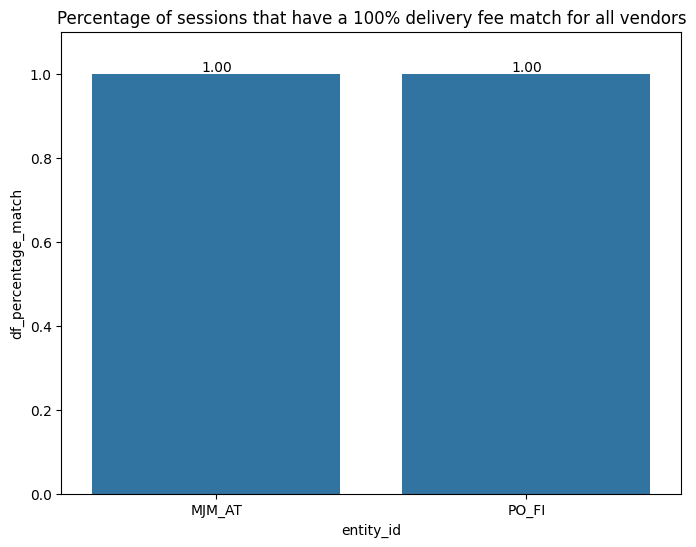

In [401]:
# Creating the conditional columns
result['sessions_df_match'] = result.apply(lambda row: 1 if row['total_vendors'] == row['delivery_fee_match'] else 0, axis=1)
# all_data['sessions_mov_match'] = all_data.apply(lambda row: 1 if row['total_vendors'] == row['mov_match'] else 0, axis=1)
# all_data['sessions_dt_match'] = all_data.apply(lambda row: 1 if row['total_vendors'] == row['delivery_time_match'] else 0, axis=1)
# all_data['sessions_time_match'] = all_data.apply(lambda row: 1 if row['total_vendors'] == row['event_time_match'] else 0, axis=1)


a = result.groupby('entity_id').agg({'sessions_df_match': 'sum','session_key':'nunique'}).reset_index()

# Calculating the percentage mismatch
a['df_percentage_match'] = a['sessions_df_match'] / a['session_key']
# a['mov_percentage_match'] = a['sessions_mov_match'] / a['session_key']
# a['dt_percentage_match'] = a['sessions_dt_match'] / a['session_key']
# a['time_percentage_match'] = a['sessions_time_match'] / a['session_key']


# Sorting the data in descending order for each plot
a_sorted_df = a.sort_values(by='df_percentage_match', ascending=False)
# a_sorted_mov = a.sort_values(by='mov_percentage_match', ascending=False)
# a_sorted_dt = a.sort_values(by='dt_percentage_match', ascending=False)
# a_sorted_time = a.sort_values(by='time_percentage_match', ascending=False)


columns_to_plot_sorted = [
    ('df_percentage_match', 'Percentage of sessions that have a 100% delivery fee match for all vendors', a_sorted_df)
    # ('mov_percentage_match', 'Percentage of sessions that have a 100% MOV match for all vendors', a_sorted_mov),
    # ('dt_percentage_match', 'Percentage of sessions that have a 100% delivery time match for all vendors', a_sorted_dt),
    # ('time_percentage_match', 'Percentage of sessions that have a 100% event time match for all vendors', a_sorted_dt)
]

for column, title, sorted_data in columns_to_plot_sorted:
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='entity_id', y=column, data=sorted_data)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')
    plt.ylim(0, 1.1)
    plt.ylabel(column)
    plt.title(title)
    plt.show()


# # List of columns to plot
# columns_to_plot = [
#     ('df_percentage_match', 'Percentage of sessions that have a 100% delivery fee match for all vendors'),
#     ('mov_percentage_match', 'Percentage of sessions that have a 100% MOV match for all vendors'),
#     ('dt_percentage_match', 'Percentage of sessions that have a 100% delivery time match for all vendors')
# ]

# # Loop to create each plot
# for column, title in columns_to_plot:
#     plt.figure(figsize=(8, 6))
#     ax = sns.barplot(x='entity_id', y=column, data=a)
#     for p in ax.patches:
#         height = p.get_height()
#         ax.annotate(f'{height:.2f}', 
#                     (p.get_x() + p.get_width() / 2., height),
#                     ha='center', va='bottom')
#     plt.ylim(0, 1.1)
#     plt.ylabel(column)
#     plt.title(title)
#     plt.show()


# # Plotting with seaborn
# plt.figure(figsize=(8, 6))
# ax = sns.barplot(x='entity_id', y='df_percentage_match', data=a)

# # Adding percentage labels on top of the bars
# for p in ax.patches:
#     height = p.get_height()
#     ax.annotate(f'{height:.2f}', 
#                 (p.get_x() + p.get_width() / 2., height),
#                 ha='center', va='bottom')

# plt.ylim(0, 1.1)  # Extend y-axis limit to make sure labels fit within the plot
# plt.ylabel('df_percentage_match')
# plt.title('Percentage of sessions that have a 100 % delivery fee match for all vendors ')
# plt.show()

In [382]:
session_completeness = all_data.groupby('entity_id').agg({'total_vendors':'sum','non_null_mov_dps':'sum','non_null_mov_impressions':'sum'
                                   ,'non_null_df_dps':'sum','non_null_df_impressions':'sum'
                                   ,'non_null_dt_dps':'sum','non_null_dt_impressions':'sum', 'non_null_event_t_dps':'sum','non_null_event_t_impressions':'sum' }).reset_index()

session_completeness['mov_dps_completeness'] = session_completeness['non_null_mov_dps'] / session_completeness['total_vendors']
session_completeness['mov_impressions_completeness'] = session_completeness['non_null_mov_impressions'] / session_completeness['total_vendors']

session_completeness['df_dps_completeness'] = session_completeness['non_null_df_dps'] / session_completeness['total_vendors']
session_completeness['df_impressions_completeness'] = session_completeness['non_null_df_impressions'] / session_completeness['total_vendors']

session_completeness['dt_dps_completeness'] = session_completeness['non_null_dt_dps'] / session_completeness['total_vendors']
session_completeness['dt_impressions_completeness'] = session_completeness['non_null_dt_impressions'] / session_completeness['total_vendors']

session_completeness['event_t_dps_completeness'] = session_completeness['non_null_event_t_dps'] / session_completeness['total_vendors']
session_completeness['event_t_impressions_completeness'] = session_completeness['non_null_event_t_impressions'] / session_completeness['total_vendors']


# Define pairs of columns for plotting
pairs = [
     ('event_t_dps_completeness', 'event_t_impressions_completeness'),
    ('mov_dps_completeness', 'mov_impressions_completeness'),
    ('df_dps_completeness', 'df_impressions_completeness'),
    ('dt_dps_completeness', 'dt_impressions_completeness')
]

# # Calculations
# session_completeness['mov_dps_completeness'] = session_completeness['non_null_mov_dps'] / session_completeness['total_vendors']
# session_completeness['mov_impressions_completeness'] = session_completeness['non_null_mov_impressions'] / session_completeness['total_vendors']
# session_completeness['df_dps_completeness'] = session_completeness['non_null_df_dps'] / session_completeness['total_vendors']
# session_completeness['df_impressions_completeness'] = session_completeness['non_null_df_impressions'] / session_completeness['total_vendors']
# session_completeness['dt_dps_completeness'] = session_completeness['non_null_dt_dps'] / session_completeness['total_vendors']
# session_completeness['dt_impressions_completeness'] = session_completeness['non_null_dt_impressions'] / session_completeness['total_vendors']
# session_completeness['event_t_dps_completeness'] = session_completeness['non_null_event_t_dps'] / session_completeness['total_vendors']
# session_completeness['event_t_impressions_completeness'] = session_completeness['non_null_event_t_impressions'] / session_completeness['total_vendors']

# # Define pairs of columns for plotting
# pairs = [
#     ('mov_dps_completeness', 'mov_impressions_completeness'),
#     ('df_dps_completeness', 'df_impressions_completeness'),
#     ('dt_dps_completeness', 'dt_impressions_completeness'),
#     ('event_t_dps_completeness', 'event_t_impressions_completeness')
# ]

# Plotting the charts using a loop with bar charts and annotations
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 18))

width = 0.35  # the width of the bars
x = range(len(session_completeness['entity_id']))  # Use range for categorical x-axis

for ax, (col1, col2) in zip(axes, pairs):
    bars1 = ax.bar([i - width/2 for i in x], session_completeness[col1], width, label=col1)
    bars2 = ax.bar([i + width/2 for i in x], session_completeness[col2], width, label=col2)
    
    # Adding annotations
    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2 - 0.18, yval, round(yval, 2), va='bottom')  # va: vertical alignment
    
    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2 - 0.18, yval, round(yval, 2), va='bottom')  # va: vertical alignment

    ax.set_title(f'{col1.replace("_", " ").title()} and {col2.replace("_", " ").title()} by Entity')
    ax.set_xlabel('Entity ID')
    ax.set_ylabel('Completeness')
    ax.set_xticks(x)
    ax.set_xticklabels(session_completeness['entity_id'])
    ax.legend()

plt.tight_layout()
plt.show()

KeyError: "Column(s) ['non_null_df_dps', 'non_null_df_impressions', 'non_null_dt_dps', 'non_null_dt_impressions', 'non_null_event_t_dps', 'non_null_event_t_impressions', 'non_null_mov_dps', 'non_null_mov_impressions', 'total_vendors'] do not exist"

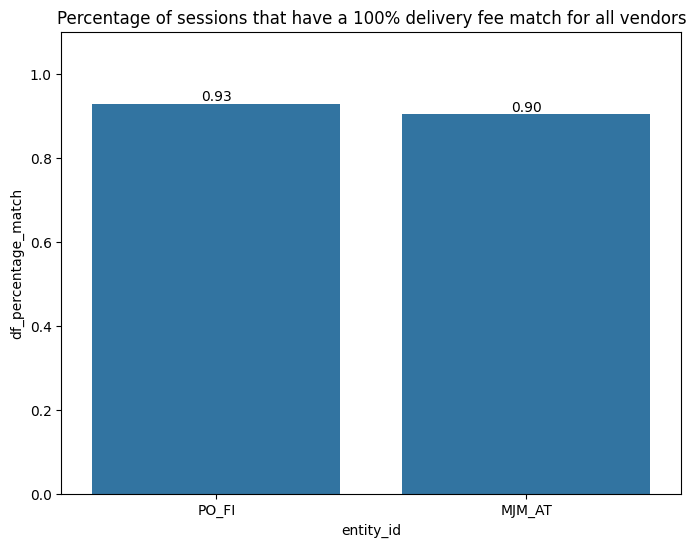

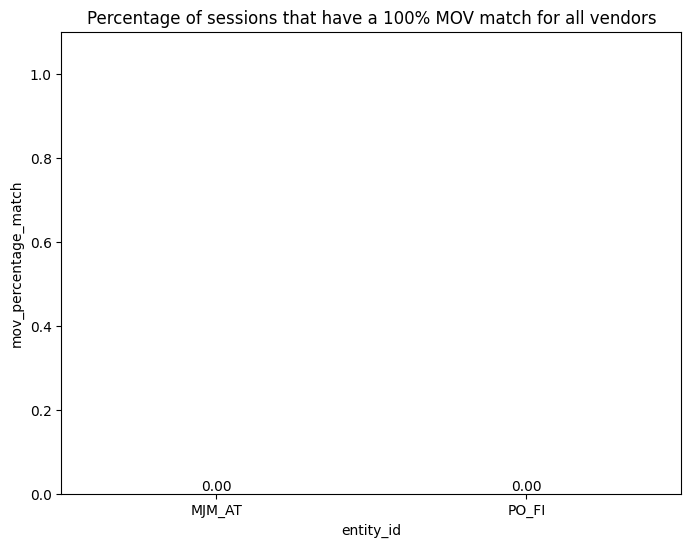

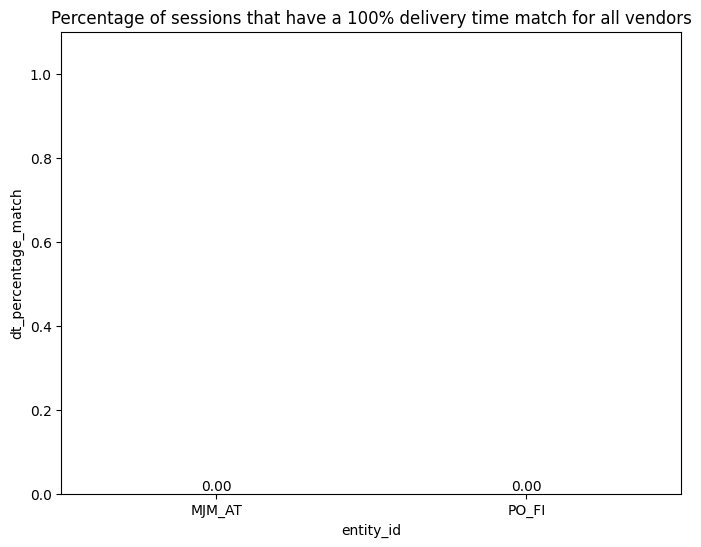

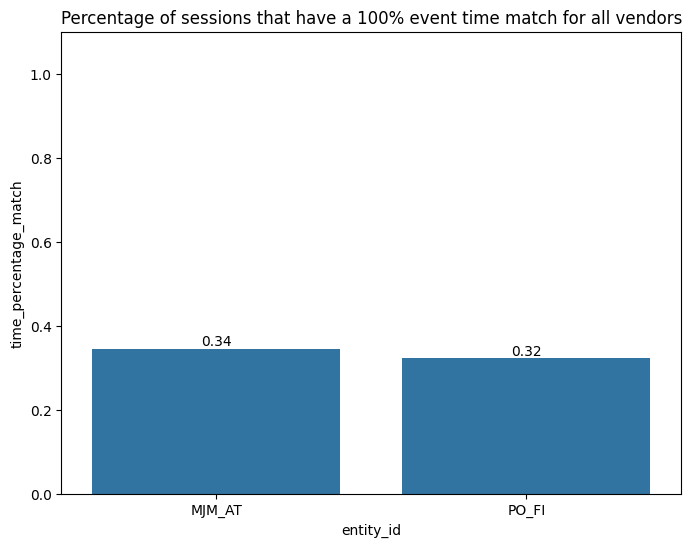

In [346]:
# Creating the conditional columns
all_data['sessions_df_match'] = all_data.apply(lambda row: 1 if row['total_vendors'] == row['delivery_fee_match'] else 0, axis=1)
all_data['sessions_mov_match'] = all_data.apply(lambda row: 1 if row['total_vendors'] == row['mov_match'] else 0, axis=1)
all_data['sessions_dt_match'] = all_data.apply(lambda row: 1 if row['total_vendors'] == row['delivery_time_match'] else 0, axis=1)
all_data['sessions_time_match'] = all_data.apply(lambda row: 1 if row['total_vendors'] == row['event_time_match'] else 0, axis=1)


a = all_data.groupby('entity_id').agg({'sessions_df_match': 'sum','sessions_mov_match':'sum','sessions_dt_match':'sum','sessions_time_match':'sum', 'session_key': 'count'}).reset_index()

# Calculating the percentage mismatch
a['df_percentage_match'] = a['sessions_df_match'] / a['session_key']
a['mov_percentage_match'] = a['sessions_mov_match'] / a['session_key']
a['dt_percentage_match'] = a['sessions_dt_match'] / a['session_key']
a['time_percentage_match'] = a['sessions_time_match'] / a['session_key']


# Sorting the data in descending order for each plot
a_sorted_df = a.sort_values(by='df_percentage_match', ascending=False)
a_sorted_mov = a.sort_values(by='mov_percentage_match', ascending=False)
a_sorted_dt = a.sort_values(by='dt_percentage_match', ascending=False)
a_sorted_time = a.sort_values(by='time_percentage_match', ascending=False)


columns_to_plot_sorted = [
    ('df_percentage_match', 'Percentage of sessions that have a 100% delivery fee match for all vendors', a_sorted_df),
    ('mov_percentage_match', 'Percentage of sessions that have a 100% MOV match for all vendors', a_sorted_mov),
    ('dt_percentage_match', 'Percentage of sessions that have a 100% delivery time match for all vendors', a_sorted_dt),
    ('time_percentage_match', 'Percentage of sessions that have a 100% event time match for all vendors', a_sorted_dt)
]

for column, title, sorted_data in columns_to_plot_sorted:
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='entity_id', y=column, data=sorted_data)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')
    plt.ylim(0, 1.1)
    plt.ylabel(column)
    plt.title(title)
    plt.show()


# # List of columns to plot
# columns_to_plot = [
#     ('df_percentage_match', 'Percentage of sessions that have a 100% delivery fee match for all vendors'),
#     ('mov_percentage_match', 'Percentage of sessions that have a 100% MOV match for all vendors'),
#     ('dt_percentage_match', 'Percentage of sessions that have a 100% delivery time match for all vendors')
# ]

# # Loop to create each plot
# for column, title in columns_to_plot:
#     plt.figure(figsize=(8, 6))
#     ax = sns.barplot(x='entity_id', y=column, data=a)
#     for p in ax.patches:
#         height = p.get_height()
#         ax.annotate(f'{height:.2f}', 
#                     (p.get_x() + p.get_width() / 2., height),
#                     ha='center', va='bottom')
#     plt.ylim(0, 1.1)
#     plt.ylabel(column)
#     plt.title(title)
#     plt.show()


# # Plotting with seaborn
# plt.figure(figsize=(8, 6))
# ax = sns.barplot(x='entity_id', y='df_percentage_match', data=a)

# # Adding percentage labels on top of the bars
# for p in ax.patches:
#     height = p.get_height()
#     ax.annotate(f'{height:.2f}', 
#                 (p.get_x() + p.get_width() / 2., height),
#                 ha='center', va='bottom')

# plt.ylim(0, 1.1)  # Extend y-axis limit to make sure labels fit within the plot
# plt.ylabel('df_percentage_match')
# plt.title('Percentage of sessions that have a 100 % delivery fee match for all vendors ')
# plt.show()

In [347]:
match = all_data.groupby('entity_id').agg({'session_key':'nunique','sessions_df_match':'sum'}).reset_index()
match['sessions_with_no_match'] = match['session_key'] - match['sessions_df_match']

match['match_perc'] = match['sessions_df_match'] / match['session_key'] 

match['no_match_perc'] = match['sessions_with_no_match'] / match['session_key'] 

match

,entity_id,session_key,sessions_df_match,sessions_with_no_match,match_perc,no_match_perc
0,MJM_AT,1632860,1476349,156511,0.904149,0.095851
1,PO_FI,824152,765244,58908,0.928523,0.071477


In [352]:
all_data

,entity_id,session_key,sessions,total_vendors,non_null_event_t_dps,non_null_event_t_impressions,non_null_df_dps,non_null_df_impressions,non_null_mov_dps,non_null_mov_impressions,...,non_null_dt_impressions,df_match,delivery_fee_match,mov_match,delivery_time_match,event_time_match,sessions_df_match,sessions_mov_match,sessions_dt_match,sessions_time_match
0,MJM_AT,M/4/o7SIZFqw0EReLqK7vA==,1,47,47,47,46,46,46,0,...,0,0,46,0,0,40,0,0,0,0
1,MJM_AT,3UunnsnW3cPm+9cI7AL1qw==,1,51,51,51,51,51,51,0,...,0,0,51,0,0,39,1,0,0,0
2,MJM_AT,gybpJZiK5cPS8EXheSMTJQ==,1,222,222,222,222,222,222,0,...,0,0,222,0,0,170,1,0,0,0
3,MJM_AT,7SNm4J10+tU5kHV6u/vw3A==,1,52,52,52,52,52,52,0,...,0,0,52,0,0,44,1,0,0,0
4,MJM_AT,riPdfABtmF/D7zRrDjKEvg==,1,39,39,39,39,39,39,0,...,0,0,39,0,0,9,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457007,PO_FI,j8fFfV/1mjDesiQj/V5iHw==,1,31,31,31,31,31,31,0,...,0,0,31,0,0,30,1,0,0,0
2457008,PO_FI,P6S/zwUSC/8ohVbsQByDDQ==,1,31,31,31,31,31,31,0,...,0,0,31,0,0,23,1,0,0,0
2457009,PO_FI,/ztRgsuIdwRYva+EcjOkPg==,1,31,31,31,31,31,31,0,...,0,0,31,0,0,29,1,0,0,0
2457010,PO_FI,xmRexQV26x7/VEHCiVlFFg==,1,31,31,31,31,31,31,0,...,0,0,31,0,0,24,1,0,0,0


In [306]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
start_date = '2024-06-01'
end_date = '2024-06-01'
# start_date_dps = '2024-05-31'
# end_date_dps = '2024-06-01'

# entity_id = ('DJ_CZ','FO_NO','MJM_AT','NP_HU','OP_SE','PO_FI','YS_TR','EF_GR','FY_CY','FP_BD',
#                 'FP_HK','FP_KH','FP_LA','FP_MM','FP_MY','FP_PH','FP_PK','FP_SG','FP_TH','FP_TW','HS_SA','AP_PA','PY_AR','PY_BO',
#                 'PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','PY_PE','PY_PY','PY_SV','PY_UY','PY_VE','HF_EG','TB_AE',
#                 'TB_BH','TB_IQ','TB_JO','TB_KW','TB_OM','TB_QA') 

# # List of entity IDs
# entity_ids = [
#     "'DJ_CZ'", "'FO_NO'", "'MJM_AT'","'NP_HU'","'OP_SE'","'PO_FI'","'YS_TR'","'EF_GR'","'FY_CY'","'FP_BD'",
#                 "'FP_HK'","'FP_KH'","'FP_LA'","'FP_MM'","'FP_MY'","'FP_PH'","'FP_PK'","'FP_SG'","'FP_TH'","'FP_TW'","'HS_SA'","'AP_PA'","'PY_AR'","'PY_BO'",
#                 "'PY_CL'","'PY_CR'","'PY_DO'","'PY_EC'","'PY_GT'","'PY_HN'","'PY_NI'","'PY_PE'","'PY_PY'","'PY_SV'","'PY_UY'","'PY_VE'","'HF_EG'","'TB_AE'",
#                 "'TB_BH'","'TB_IQ'","'TB_JO'","'TB_KW'","'TB_OM'","'TB_QA'" 
# ]

# List of entity IDs
entity_ids = [
    "'DJ_CZ'", "'FO_NO'", "'MJM_AT'","'NP_HU'","'OP_SE'","'PO_FI'","'YS_TR'","'EF_GR'","'FY_CY'","'FP_BD'"
]


# Function to query data for a given entity ID
def query_impression_data(entity_id, start_date, end_date):
    return client.query(impression_data_q(start_date, end_date, entity_id)).to_dataframe()

# Initialize an empty list to hold dataframes
dataframes = []

# Loop through each entity ID, query the data, and append the dataframe to the list
for entity_id in entity_ids:
    df = query_impression_data(entity_id, start_date, end_date)
    dataframes.append(df)

# Concatenate all the dataframes into a single dataframe
all_data = pd.concat(dataframes, ignore_index=True)



/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


KeyboardInterrupt: 

In [183]:
session_completeness

,entity_id,total_vendors,non_null_mov_dps,non_null_mov_impressions,non_null_df_dps,non_null_df_impressions,non_null_dt_dps,non_null_dt_impressions,mov_dps_completeness,mov_impressions_completeness,df_dps_completeness,df_impressions_completeness,dt_dps_completeness,dt_impressions_completeness
0,DJ_CZ,746763,733612,0,745626,745732,718016,0,0.982389,0.0,0.998477,0.998619,0.961505,0.0
1,EF_GR,644161,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,FO_NO,484797,475584,0,481657,481705,454241,0,0.980996,0.0,0.993523,0.993622,0.936972,0.0
3,FP_BD,2754043,2689940,0,2742178,2742822,2680227,0,0.976724,0.0,0.995692,0.995926,0.973197,0.0
4,MJM_AT,830325,814043,0,824653,824833,784672,0,0.980391,0.0,0.993169,0.993386,0.945018,0.0
5,NP_HU,811359,796819,0,810370,810580,784838,0,0.982079,0.0,0.998781,0.99904,0.967313,0.0
6,OP_SE,1242438,1226263,0,1240416,1240605,1196152,0,0.986981,0.0,0.998373,0.998525,0.962746,0.0
7,PO_FI,339522,331739,0,339257,339324,325138,0,0.977077,0.0,0.999219,0.999417,0.957635,0.0
8,YS_TR,19018712,18894253,0,18992557,18998044,18564707,0,0.993456,0.0,0.998625,0.998913,0.976129,0.0


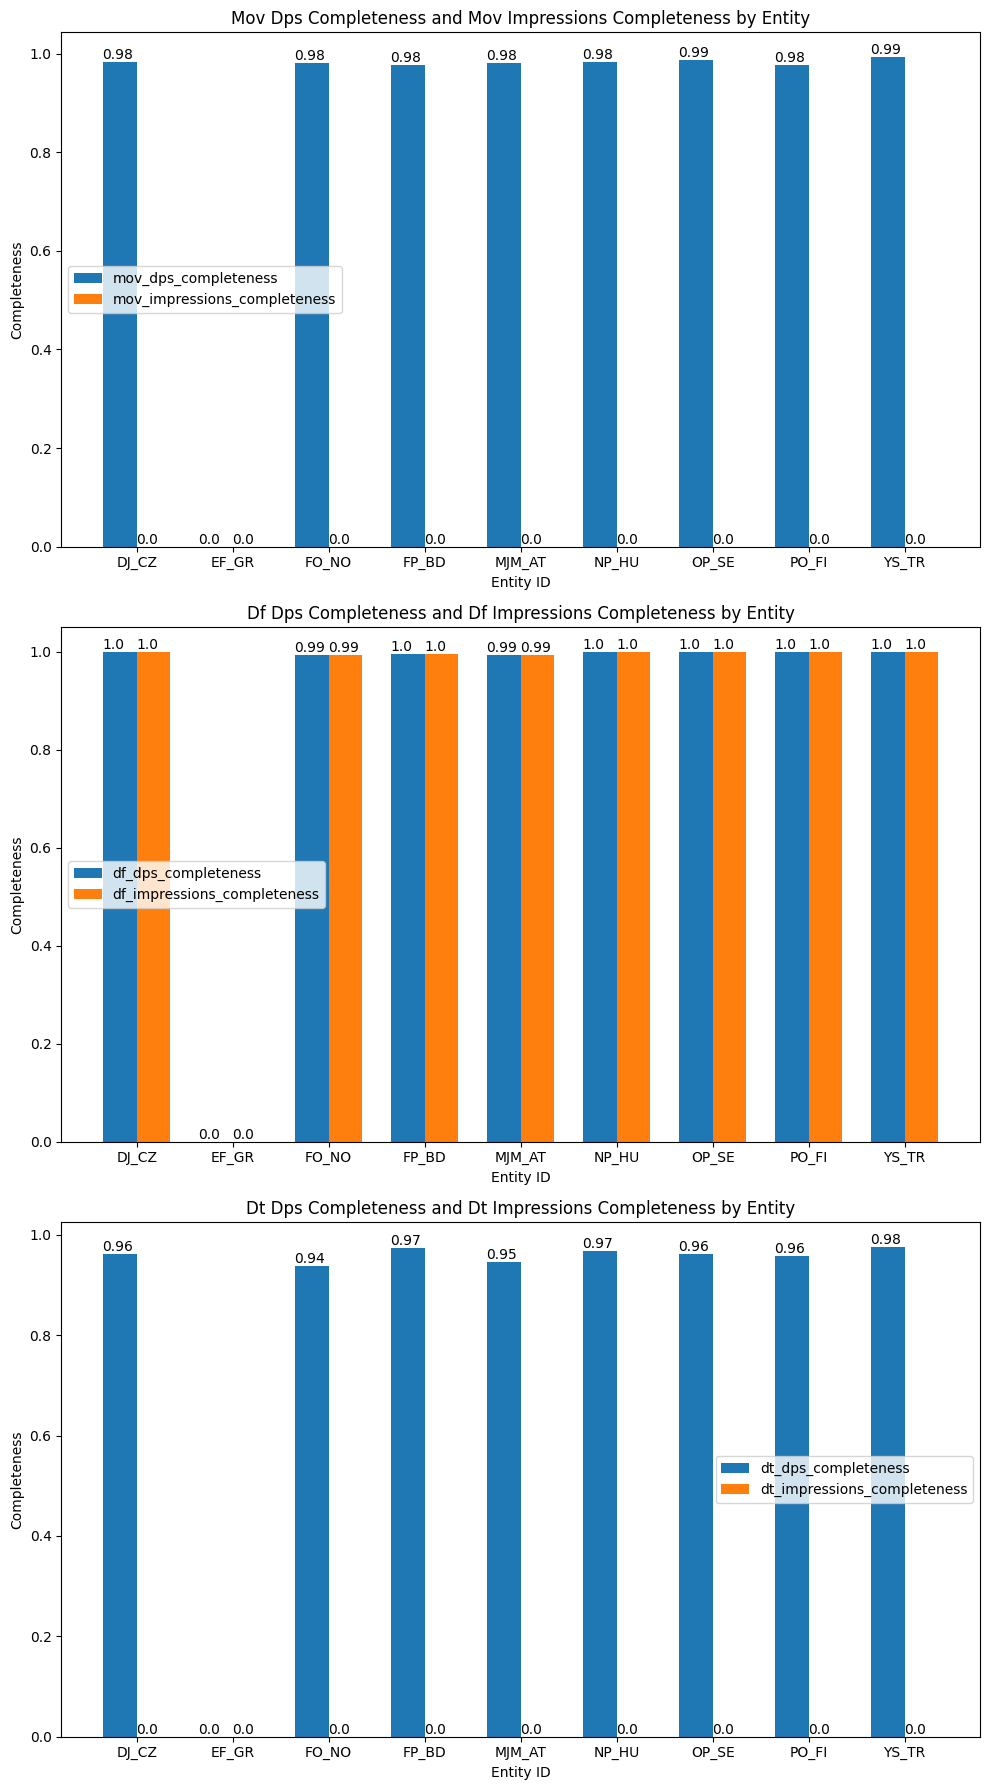

In [194]:
session_completeness = all_data.groupby('entity_id').agg({'total_vendors':'sum','non_null_mov_dps':'sum','non_null_mov_impressions':'sum'
                                   ,'non_null_df_dps':'sum','non_null_df_impressions':'sum'
                                   ,'non_null_dt_dps':'sum','non_null_dt_impressions':'sum' }).reset_index()

session_completeness['mov_dps_completeness'] = session_completeness['non_null_mov_dps'] / session_completeness['total_vendors']
session_completeness['mov_impressions_completeness'] = session_completeness['non_null_mov_impressions'] / session_completeness['total_vendors']

session_completeness['df_dps_completeness'] = session_completeness['non_null_df_dps'] / session_completeness['total_vendors']
session_completeness['df_impressions_completeness'] = session_completeness['non_null_df_impressions'] / session_completeness['total_vendors']

session_completeness['dt_dps_completeness'] = session_completeness['non_null_dt_dps'] / session_completeness['total_vendors']
session_completeness['dt_impressions_completeness'] = session_completeness['non_null_dt_impressions'] / session_completeness['total_vendors']


# Define pairs of columns for plotting
pairs = [
    ('mov_dps_completeness', 'mov_impressions_completeness'),
    ('df_dps_completeness', 'df_impressions_completeness'),
    ('dt_dps_completeness', 'dt_impressions_completeness')
]

# Calculations
session_completeness['mov_dps_completeness'] = session_completeness['non_null_mov_dps'] / session_completeness['total_vendors']
session_completeness['mov_impressions_completeness'] = session_completeness['non_null_mov_impressions'] / session_completeness['total_vendors']
session_completeness['df_dps_completeness'] = session_completeness['non_null_df_dps'] / session_completeness['total_vendors']
session_completeness['df_impressions_completeness'] = session_completeness['non_null_df_impressions'] / session_completeness['total_vendors']
session_completeness['dt_dps_completeness'] = session_completeness['non_null_dt_dps'] / session_completeness['total_vendors']
session_completeness['dt_impressions_completeness'] = session_completeness['non_null_dt_impressions'] / session_completeness['total_vendors']

# Define pairs of columns for plotting
pairs = [
    ('mov_dps_completeness', 'mov_impressions_completeness'),
    ('df_dps_completeness', 'df_impressions_completeness'),
    ('dt_dps_completeness', 'dt_impressions_completeness')
]

# Plotting the charts using a loop with bar charts and annotations
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

width = 0.35  # the width of the bars
x = range(len(session_completeness['entity_id']))  # Use range for categorical x-axis

for ax, (col1, col2) in zip(axes, pairs):
    bars1 = ax.bar([i - width/2 for i in x], session_completeness[col1], width, label=col1)
    bars2 = ax.bar([i + width/2 for i in x], session_completeness[col2], width, label=col2)
    
    # Adding annotations
    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2 - 0.18, yval, round(yval, 2), va='bottom')  # va: vertical alignment
    
    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2 - 0.18, yval, round(yval, 2), va='bottom')  # va: vertical alignment

    ax.set_title(f'{col1.replace("_", " ").title()} and {col2.replace("_", " ").title()} by Entity')
    ax.set_xlabel('Entity ID')
    ax.set_ylabel('Completeness')
    ax.set_xticks(x)
    ax.set_xticklabels(session_completeness['entity_id'])
    ax.legend()

plt.tight_layout()
plt.show()

In [200]:
session_completeness[['dt_dps_completeness','dt_impressions_completeness']]

,dt_dps_completeness,dt_impressions_completeness
0,0.961505,0.0
1,0.0,0.0
2,0.936972,0.0
3,0.973197,0.0
4,0.945018,0.0
5,0.967313,0.0
6,0.962746,0.0
7,0.957635,0.0
8,0.976129,0.0


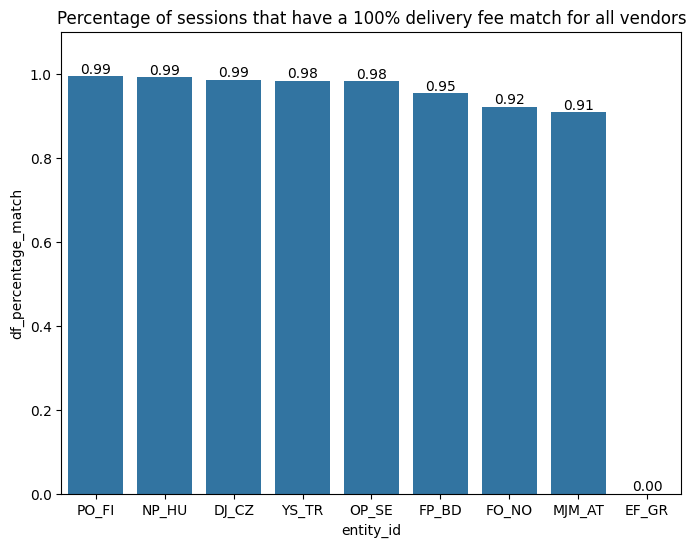

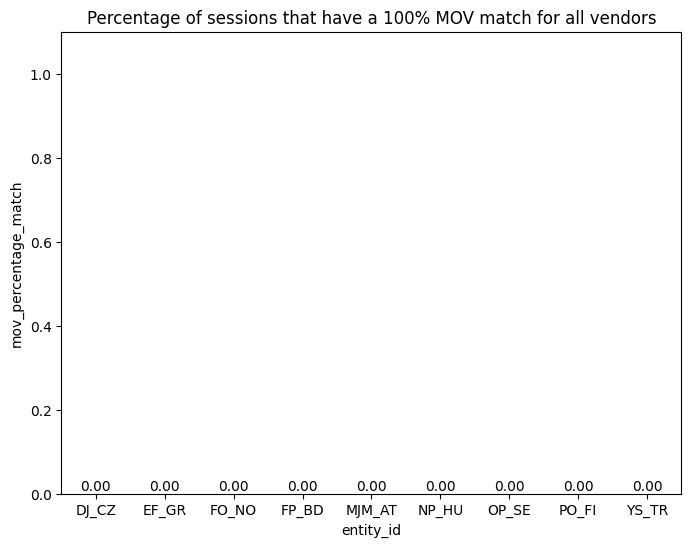

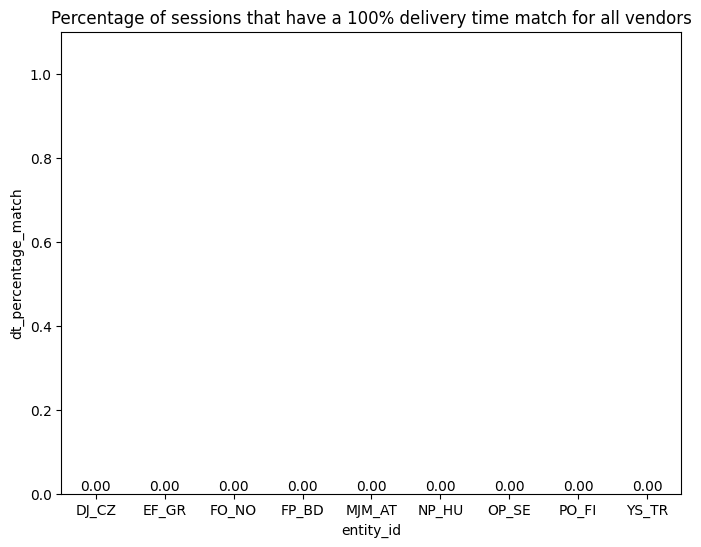

In [195]:
# Creating the conditional columns
all_data['sessions_df_match'] = all_data.apply(lambda row: 1 if row['total_vendors'] == row['delivery_fee_match'] else 0, axis=1)
all_data['sessions_mov_match'] = all_data.apply(lambda row: 1 if row['total_vendors'] == row['mov_match'] else 0, axis=1)
all_data['sessions_dt_match'] = all_data.apply(lambda row: 1 if row['total_vendors'] == row['delivery_time_match'] else 0, axis=1)

a = all_data.groupby('entity_id').agg({'sessions_df_match': 'sum','sessions_mov_match':'sum','sessions_dt_match':'sum', 'session_key': 'count'}).reset_index()

# Calculating the percentage mismatch
a['df_percentage_match'] = a['sessions_df_match'] / a['session_key']
a['mov_percentage_match'] = a['sessions_mov_match'] / a['session_key']
a['dt_percentage_match'] = a['sessions_dt_match'] / a['session_key']

# Sorting the data in descending order for each plot
a_sorted_df = a.sort_values(by='df_percentage_match', ascending=False)
a_sorted_mov = a.sort_values(by='mov_percentage_match', ascending=False)
a_sorted_dt = a.sort_values(by='dt_percentage_match', ascending=False)

columns_to_plot_sorted = [
    ('df_percentage_match', 'Percentage of sessions that have a 100% delivery fee match for all vendors', a_sorted_df),
    ('mov_percentage_match', 'Percentage of sessions that have a 100% MOV match for all vendors', a_sorted_mov),
    ('dt_percentage_match', 'Percentage of sessions that have a 100% delivery time match for all vendors', a_sorted_dt)
]

for column, title, sorted_data in columns_to_plot_sorted:
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='entity_id', y=column, data=sorted_data)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')
    plt.ylim(0, 1.1)
    plt.ylabel(column)
    plt.title(title)
    plt.show()


# # List of columns to plot
# columns_to_plot = [
#     ('df_percentage_match', 'Percentage of sessions that have a 100% delivery fee match for all vendors'),
#     ('mov_percentage_match', 'Percentage of sessions that have a 100% MOV match for all vendors'),
#     ('dt_percentage_match', 'Percentage of sessions that have a 100% delivery time match for all vendors')
# ]

# # Loop to create each plot
# for column, title in columns_to_plot:
#     plt.figure(figsize=(8, 6))
#     ax = sns.barplot(x='entity_id', y=column, data=a)
#     for p in ax.patches:
#         height = p.get_height()
#         ax.annotate(f'{height:.2f}', 
#                     (p.get_x() + p.get_width() / 2., height),
#                     ha='center', va='bottom')
#     plt.ylim(0, 1.1)
#     plt.ylabel(column)
#     plt.title(title)
#     plt.show()


# # Plotting with seaborn
# plt.figure(figsize=(8, 6))
# ax = sns.barplot(x='entity_id', y='df_percentage_match', data=a)

# # Adding percentage labels on top of the bars
# for p in ax.patches:
#     height = p.get_height()
#     ax.annotate(f'{height:.2f}', 
#                 (p.get_x() + p.get_width() / 2., height),
#                 ha='center', va='bottom')

# plt.ylim(0, 1.1)  # Extend y-axis limit to make sure labels fit within the plot
# plt.ylabel('df_percentage_match')
# plt.title('Percentage of sessions that have a 100 % delivery fee match for all vendors ')
# plt.show()

In [196]:
a

,entity_id,sessions_df_match,sessions_mov_match,sessions_dt_match,session_key,df_percentage_match,mov_percentage_match,dt_percentage_match
0,DJ_CZ,53264,0,0,54038,0.985677,0.0,0.0
1,EF_GR,0,0,0,46374,0.000000,0.0,0.0
2,FO_NO,36119,0,0,39193,0.921568,0.0,0.0
3,FP_BD,162023,0,0,169954,0.953334,0.0,0.0
4,MJM_AT,48616,0,0,53563,0.907641,0.0,0.0
5,NP_HU,58209,0,0,58655,0.992396,0.0,0.0
6,OP_SE,92746,0,0,94428,0.982187,0.0,0.0
7,PO_FI,30229,0,0,30436,0.993199,0.0,0.0
8,YS_TR,1229479,0,0,1250723,0.983015,0.0,0.0


In [ ]:
# def impression_data_q(start_d, end_d, entity_d):

#         query = f"""
#        with impression_data as (
#         select * 
#         from (
#         SELECT 
#                 session_key
#                 ,eventAction
#                 ,eventTimestamp
#                 ,event_timestamp_local
#                 ,TIMESTAMP_TRUNC(event_timestamp_local, SECOND) event_t
#                 ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
#                 ,platform AS platform
#                 ,sessionId AS perseus_session_id
#                 ,hitMatchId AS perseus_hit_match_id
#                 ,ROW_NUMBER() OVER (PARTITION BY session_key,shopId ORDER BY event_timestamp_local) row_num
#                 ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
#                 ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
#                 ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
#                 ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
#                 ,json_value(eventVariables_json, "$.shopRatingQuality")  AS quality_impressions
#                 ,json_value(eventVariables_json, "$.businessType")  AS bt_impressions
#                 ,json_value(eventVariables_json, "$.shopRatingQuantity") AS quantity_impressions
#                 ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS mov_impressions
#                 ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS df_impressions 
#                 ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS dt_impressions
#         FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#         WHERE partition_date BETWEEN \"""" + start_d + """\" and \"""" + end_d + """\"
#                 AND eventAction = 'shop_impressions.loaded'
#                 AND global_entity_id = """ + entity_d + """
#                 --AND session_key = "SlXTIyTYecRbys2s4lOZUA=="
#         ORDER BY eventTimestamp
#         )
#         where row_num = 1
#         ),dps_data as (
#         select *
#         from 
#         (
#         SELECT  perseus_session_key
#                 ,entity_id
#                 ,row_number() over (partition by perseus_session_key, vendor_code order by event_time) row_num
#                 ,a.event_time event_time
#                 ,TIMESTAMP_TRUNC(a.event_time, SECOND) event_t
#                 ,a.vendor_code
#                 ,a.vendor_delivery_fee df_dps
#                 ,a.minimum_order_value mov_dps
#                 ,a.vendor_delivery_time dt_dps
#         FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` 
#         cross join unnest (events) as a
#         WHERE created_date BETWEEN \"""" + start_d + """\" and \"""" + end_d + """\"
#         AND perseus_session_key is not null
#         AND a.event_action = 'shop_impressions.loaded'
#         AND entity_id = """ + entity_d + """
#         --AND perseus_session_key = 'SlXTIyTYecRbys2s4lOZUA=='
#         ) 
#         where row_num = 1
#         )
#         select   coalesce(id.global_entity_id, dpsd.entity_id) entity_id
#                 ,coalesce(id.session_key,perseus_session_key) session_key
#                 ,count(*) total_vendors
#                 ,count(df_dps) non_null_df_dps
#                 ,count(df_impressions) non_null_df_impressions
#                 ,count(mov_dps) non_null_mov_dps
#                 ,count(mov_impressions) non_null_mov_impressions
#                 ,count(dt_dps) non_null_dt_dps
#                 ,count(dt_impressions) non_null_dt_impressions
#                 ,count (case when (df_dps = df_impressions) or (df_dps is null and df_impressions is null) then coalesce(shopId,vendor_code) end) as delivery_fee_match
#                 ,count (case when (mov_dps = mov_impressions) or (mov_dps is null and mov_impressions is null) then coalesce(shopId,vendor_code) end) as mov_match
#                 ,count (case when (dt_dps = dt_impressions) or (dt_dps is null and dt_impressions is null) then coalesce(shopId,vendor_code) end) as delivery_time_match
#         from impression_data as id
#         left join dps_data as dpsd on dpsd.perseus_session_key = id.session_key and id.global_entity_id = dpsd.entity_id and dpsd.vendor_code = id.shopId
#         group by 1,2
#         """
        
#         return query

In [124]:
# abc = f"""
# SELECT 
#     session_key,
#     eventAction,
#     eventTimestamp,
#     eventVariables_json,
#     global_entity_id,
#     JSON_VALUE(eventVariables_json, "$.globalEntityId")
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#     WHERE partition_date = '2024-06-18'
#     AND session_key = 'SlXTIyTYecRbys2s4lOZUA=='

# """





# c = client.query(abc).to_dataframe()
# c

In [125]:
# dict = {}

# for key, value in c['eventVariables_json'][0].items():
#     if value != None:
#         print(key, value)
#         dict[key] = value

In [126]:
# pd.DataFrame(dict.items(), columns=['Key', 'Value'])

In [127]:
# query = f"""
#       SELECT  eventAction
#       FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` 
#             LEFT JOIN UNNEST(eventVariables) v1 ON v1.name = 'globalEntityId' 
#       WHERE partition_date = "2024-06-18" 
#             AND session_key is not null
#             AND COALESCE(global_entity_id, v1.value) = 'PY_PE'
#       group by 1
# """

# test = client.query(query).to_dataframe()
# test

In [128]:
# test.to_csv()

In [129]:
# def impression_data_q(start_d, end_d, start_d_dps, end_d_dps, e_id):

#         query = f"""
#         with impression_data as (
#         SELECT 
#                 DISTINCT
#                 session_key
#                 ,COALESCE(global_entity_id, v1.value) AS global_entity_id
#                 ,COALESCE(platform, v2.value) AS platform
#                 ,COALESCE(shopId, v7.value) AS shopId
#                 ,COALESCE(v13.value, '') AS mov_impressions
#                 ,COALESCE(v14.value, '') AS df_impressions
#                 ,COALESCE(v15.value, '') AS dt_impressions
#                 ,eventAction
#         FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events` 
#         LEFT JOIN UNNEST(eventVariables) v1 ON v1.name = 'globalEntityId'
#         LEFT JOIN UNNEST(eventVariables) v2 ON v2.name = 'eventPlatform'
#         LEFT JOIN UNNEST(eventVariables) v7 ON v7.name = 'shopId'
#         LEFT JOIN UNNEST(eventVariables) v13 ON v13.name = 'shopMinimumOrderValue'
#         LEFT JOIN UNNEST(eventVariables) v14 ON v14.name IN ('shopDeliveryFee', 'vendorDeliveryFee')
#         LEFT JOIN UNNEST(eventVariables) v15 ON v15.name = 'shopDeliveryTime'
#         WHERE eventAction IN ('shop_impressions.loaded')
#         AND partition_date BETWEEN \"""" + start_d + """\" and \"""" + end_d + """\"
#         AND COALESCE(global_entity_id, v1.value) = """ + e_id + """
#         --AND session_key = 'SlXTIyTYecRbys2s4lOZUA=='
#         ), dps_data as (
#         SELECT  perseus_session_key
#                 ,entity_id
#                 ,platform
#                 ,a.vendor_code
#                 ,a.vendor_delivery_fee df_dps
#                 ,a.minimum_order_value mov_dps
#                 ,a.vendor_delivery_time dt_dps
#         FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` cross join unnest (events) as a
#         WHERE created_date BETWEEN \"""" + start_d_dps + """\" and \"""" + end_d_dps + """\"
#         AND perseus_session_key is not null
#         AND a.event_action = 'shop_impressions.loaded'
#         AND entity_id = """ + e_id + """
#         --AND entity_id is not null
#         --AND perseus_session_key = 'SlXTIyTYecRbys2s4lOZUA=='
#         )
#         select   id.global_entity_id entity_id
#                 ,id.platform platform
#                 ,id.session_key session_key
#                 ,count(distinct id.shopId ) as total_vendors
#                 ,count(id.df_impressions) non_null_df_impressions
#                 ,count(id.mov_impressions) non_null_mov_impressions
#                 ,count(id.dt_impressions) non_null_dt_impressions 
#                 ,count(dpsd.df_dps) non_null_df_dps
#                 ,count(dpsd.mov_dps) non_null_mov_dps
#                 ,count(dpsd.dt_dps) non_null_dt_dps 
#                 ,count(distinct case when id.df_impressions = dpsd.df_dps then shopId else NULL end) as count_df_match
#                 ,count(distinct case when id.mov_impressions = dpsd.mov_dps then shopId else NULL end) as count_mov_match
#                 ,count(distinct case when id.dt_impressions = dpsd.dt_dps then shopId else NULL end) as count_dt_match
#         from impression_data id
#         left join dps_data dpsd on dpsd.perseus_session_key = id.session_key and dpsd.vendor_code = id.shopId
#         group by 1,2,3
#         """

#         return query


# #test = client.query(query).to_dataframe()

In [4]:
50 * 2

100

In [130]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'
# start_date_dps = '2024-05-31'
# end_date_dps = '2024-06-01'


# # entity_id = ('PY_AR','PY_BO','PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','AP_PA','PY_PE',
# #              'PY_PY','PY_SV','PY_UY','PY_VE','FP_BD','FP_KH','FP_HK','FP_LA','FP_MY','FP_MM','FP_PK','FP_PH',
# #              'FP_SG','FP_TW','FP_TH','MJM_AT','FY_CY','DJ_CZ','HN_DK','PO_FI','EF_GR','NP_HU','FO_NO','OP_SE',
# #              'FP_SK','TB_AE','HS_BH','HS_BH','TB_BH','HF_EG','TB_IQ','TB_JO','TB_KW','TB_OM','TB_QA','HS_SA','YS_TR','YS_TR')

# #entity_id = ('PY_AR','PY_BO','PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','AP_PA','PY_PE')

# entity_id = "'PY_PE'"


# impression_d = client.query(impression_data_q(start_date, end_date, start_date_dps, end_date_dps, entity_id)).to_dataframe()

In [131]:
# for entity in entity_id:
#     print(entity)

In [132]:
# # Creating the conditional columns
# test['sessions_df_match'] = test.apply(lambda row: 1 if row['total_vendors'] == row['count_df_match'] else 0, axis=1)
# test['sessions_mov_match'] = test.apply(lambda row: 1 if row['total_vendors'] == row['count_mov_match'] else 0, axis=1)
# test['sessions_dt_match'] = test.apply(lambda row: 1 if row['total_vendors'] == row['count_dt_match'] else 0, axis=1)

# a = test.groupby('entity_id').agg({'sessions_df_match': 'sum', 'session_key': 'count'}).reset_index()

# # Calculating the percentage mismatch
# a['df_percentage_match'] = a['sessions_df_match'] / a['session_key']

# # Plotting with seaborn
# plt.figure(figsize=(8, 6))
# ax = sns.barplot(x='entity_id', y='df_percentage_match', data=a)

# # Adding percentage labels on top of the bars
# for p in ax.patches:
#     height = p.get_height()
#     ax.annotate(f'{height:.2f}', 
#                 (p.get_x() + p.get_width() / 2., height),
#                 ha='center', va='bottom')

# plt.ylim(0, 1.1)  # Extend y-axis limit to make sure labels fit within the plot
# plt.ylabel('df_percentage_match')
# plt.title('Percentage of sessions that have a 100 % delivery fee match for all vendors ')
# plt.show()

In [154]:
# test[test['count_mov_match'] > 0]

In [133]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# tt = f"""
#   SELECT 
#     partition_date,
#     IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
#     session_key,
#     eventVariables
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#   WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#     AND eventAction IN ('shop_impressions.loaded')
#     AND session_key = '2hfGxiUpOdChbyOhA1YRIQ=='
# """

# test = client.query(tt).to_dataframe()


In [134]:
# print(test['eventVariables'][0])

In [153]:
# lst = []
# for item in test['eventVariables'][0]:
#     lst.append(item['name'])

In [152]:
# matching = [s for s in lst if "Vendor" in s]
# matching


In [135]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# tt = f"""
#   SELECT 
#     partition_date,
#     IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
#     session_key,
#     sessionId,
#     IFNULL(platform, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('eventPlatform'))) platform,
#     IFNULL(sessionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusSessionId'))) perseus_session_id,
#     IFNULL(hitMatchId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusHitMatchId'))) perseus_hit_match_id,
#     IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) orderId,
#     IFNULL(shopListType, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopListType'))) shopListType,
#     IFNULL(shopId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopId'))) shopId,
#     IFNULL(shopPosition, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopPosition'))) shopPosition,
#     IFNULL(eventOrigin, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('origin'))) eventOrigin,
#     IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopRatingQuality')), '') shopRatingQuality,
#     IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('businessType')), '') businessType,
#     IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopRatingQuantity')), '') shopRatingQuantity,
#     IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopMinimumOrderValue')), '') shopMinimumOrderValue,
#     IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryFee', 'vendorDeliveryFee')), '') vendor_delivery_fee,
#     IFNULL((SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryTime')), '') shopDeliveryTime
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#   WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#     AND eventAction IN ('shop_impressions.loaded')
#     AND session_key = '2hfGxiUpOdChbyOhA1YRIQ=='
# """

# test = client.query(tt).to_dataframe()


In [136]:
# tt_t = f"""
# select o.country_code, 
#   o.zone_name,
#   o.platform_order_code, 
#   o.dps_session_id,
#   o.order_id
# from fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders o
# left join fulfillment-dwh-production.cl.countries c ON o.country_code = c.country_code
# where o.dps_session_id = '1717030504197.000000001074390042.000052zlcp'
#       and o.entity_id = 'PY_EC'
# """

# test_tt = client.query(tt_t).to_dataframe()


In [137]:
# test_tt

In [138]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# orders = f"""
#     SELECT
#         country_name,
#         country_code,
#         entity_id,
#         created_date,
#         order_id
#     FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
#     where order_id = 1189995736
#     """

# orders_data_match = client.query(orders).to_dataframe()
# orders_data_match

In [139]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# query = f"""
# with impression_data as (
#   SELECT 
#     session_key
#     ,eventAction
#     ,eventTimestamp
#     ,COALESCE(global_entity_id,json_value(eventVariables_json, "$.globalEntityId") ) AS global_entity_id
#     ,platform AS platform
#     ,sessionId AS perseus_session_id
#     ,hitMatchId AS perseus_hit_match_id
#     ,COALESCE(shopListType,json_value(eventVariables_json, "$.shopListType") ) AS shopListType
#     ,COALESCE(shopId,json_value(eventVariables_json, "$.shopId") ) AS shopId
#     ,COALESCE(shopPosition,json_value(eventVariables_json, "$.shopPosition") ) AS shopPosition
#     ,COALESCE(eventOrigin,json_value(eventVariables_json, "$.origin") ) AS eventOrigin
#     ,json_value(eventVariables_json, "$.shopRatingQuality")  AS shopRatingQuality
#     ,json_value(eventVariables_json, "$.businessType")  AS businessType
#     ,json_value(eventVariables_json, "$.shopRatingQuantity") AS shopRatingQuantity
#     ,json_value(eventVariables_json, "$.shopMinimumOrderValue")  AS shopMinimumOrderValue
#     ,coalesce(json_value(eventVariables_json, "$.vendorDeliveryFee"), json_value(eventVariables_json, "$.shopDeliveryFee")) AS vendor_delivery_fee
#     ,json_value(eventVariables_json, "$.shopDeliveryTime")  AS shopDeliveryTime
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#   WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#     AND eventAction = 'shop_impressions.loaded'
# ),
# aggregation as (
# SELECT 
#   global_entity_id
#   ,count(distinct perseus_session_id) as total_sessions
#   ,count(distinct perseus_hit_match_id) as total_hits
#   ,count(*) as total_rows
#   ,count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as fee_hits
#   ,count(distinct case when shopRatingQuality is not null then perseus_hit_match_id end) as quality_hits
#   ,count(distinct case when shopRatingQuantity is not null then perseus_hit_match_id end) as quantity_hits
#   ,count(distinct case when cast(regexp_extract(shopMinimumOrderValue,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as mov_hits
#   ,count(distinct case when shopDeliveryTime is not null then perseus_hit_match_id end) as delivery_time_hits
#   ,count(distinct case when businessType is not null then perseus_hit_match_id end) as business_type_hits
# FROM impression_data
# GROUP BY 1
# )
# select a.*,
#        1.00 * (fee_hits / total_hits) fee_completeness
#        ,1.00 * (quality_hits / total_hits) quality_completeness
#        ,1.00 * (quantity_hits / total_hits ) quantity_completeness
#        ,1.00 * (mov_hits / total_hits ) mov_completeness
#        ,1.00 * (delivery_time_hits / total_hits ) deliverytime_completeness
#        ,1.00 * (business_type_hits / total_hits ) bussinesstype_completeness
# from aggregation a
# """

# impression_data_completeness = client.query(query).to_dataframe()

In [140]:
# impression_data_completeness)

In [141]:
# impression_data_completeness['entity_grouping'] = impression_data_completeness['global_entity_id'].str.split('_').str[0]
# impression_data_completeness = impression_data_completeness.dropna(subset=['global_entity_id'])

# cols = ['fee_completeness', 'quality_completeness', 'quantity_completeness', 
#         'mov_completeness', 'deliverytime_completeness', 'bussinesstype_completeness']

# impression_data_completeness = impression_data_completeness.sort_values(by = 'entity_grouping')

# x_axis_column = 'global_entity_id'

# # Extract x-axis data
# x_data = impression_data_completeness[x_axis_column]

# # Generate a colormap
# num_cols = len(cols)
# color_map = plt.cm.get_cmap('tab10')  

# # Iterate through each column in cols and plot
# for i, col in enumerate(cols):
#     # Sort data by the current column
#     sorted_data = impression_data_completeness.sort_values(by=col, ascending = False)
    
#     # Extract x-axis data
#     x_data = sorted_data[x_axis_column]

#     # Create a figure and axis for plotting
#     fig, ax = plt.subplots()
#     fig.set_size_inches(25, 10, forward=True)

#     # Plot the data with dynamically assigned color
#     color = color_map(i / num_cols)  
#     ax.bar(x_data, sorted_data[col], color=color)
    
#     ax.set_xlabel(x_axis_column, fontsize=14)
#     ax.set_ylabel(col, fontsize=14)
#     ax.set_title(f'Percentage of hits with {col}', fontsize=16)
    
#     plt.xticks(rotation=45, fontsize=18)
#     plt.yticks(fontsize=18)
    
#     # Show plot
#     plt.tight_layout()  
#     plt.show()
    

In [142]:
# impression_data_completeness['entity_grouping'] = impression_data_completeness['global_entity_id'].str.split('_').str[0]
# impression_data_completeness = impression_data_completeness.dropna(subset=['global_entity_id'])

# # Assuming 'test' is your DataFrame and 'cols' is your list of columns
# cols = ['fee_completeness', 'quality_completeness', 'quantity_completeness', 
#         'mov_completeness', 'deliverytime_completeness', 'bussinesstype_completeness']

# impression_data_completeness = impression_data_completeness.sort_values(by = 'entity_grouping')

# x_axis_column = 'global_entity_id'

# # Extract x-axis data
# x_data = impression_data_completeness[x_axis_column]

# # Generate a colormap
# num_cols = len(cols)
# color_map = plt.cm.get_cmap('tab10')  

# # Iterate through each column in cols and plot
# for i, col in enumerate(cols):
#     # Create a figure and axis for plotting
#     fig, ax = plt.subplots()
#     fig.set_size_inches(18.5, 10.5, forward=True)

#     # Plot the data with dynamically assigned color
#     color = color_map(i / num_cols)  # Use colormap to get a color
#     ax.bar(x_data, impression_data_completeness[col], color=color)
    
#     # Set labels and title
#     ax.set_xlabel(x_axis_column)
#     ax.set_ylabel(col)
#     ax.set_title(f'Percentage of hits with {col}')
    
#     # Optionally, rotate x-axis labels if needed
#     plt.xticks(rotation=45)
    
#     # Show plot
#     plt.tight_layout()  # Adjust layout for better presentation
#     plt.show()

In [143]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# query = f"""
# with impression_data as (
#   SELECT 
#     partition_date,
#     COALESCE(global_entity_id, v1.value) AS global_entity_id,
#     COALESCE(platform, v2.value) AS platform,
#     COALESCE(sessionId, v3.value) AS perseus_session_id,
#     COALESCE(hitMatchId, v4.value) AS perseus_hit_match_id,
#     COALESCE(transactionId, v5.value) AS orderId,
#     COALESCE(shopListType, v6.value) AS shopListType,
#     COALESCE(shopId, v7.value) AS shopId,
#     COALESCE(shopPosition, v8.value) AS shopPosition,
#     COALESCE(eventOrigin, v9.value) AS eventOrigin,
#     COALESCE(v10.value, '') AS shopRatingQuality,
#     COALESCE(v11.value, '') AS businessType,
#     COALESCE(v12.value, '') AS shopRatingQuantity,
#     COALESCE(v13.value, '') AS shopMinimumOrderValue,
#     COALESCE(v14.value, '') AS vendor_delivery_fee,
#     COALESCE(v15.value, '') AS shopDeliveryTime
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#   LEFT JOIN UNNEST(eventVariables) v1 ON v1.name IN ('globalEntityId')
#   LEFT JOIN UNNEST(eventVariables) v2 ON v2.name IN ('eventPlatform')
#   LEFT JOIN UNNEST(eventVariables) v3 ON v3.name IN ('perseusSessionId')
#   LEFT JOIN UNNEST(eventVariables) v4 ON v4.name IN ('perseusHitMatchId')
#   LEFT JOIN UNNEST(eventVariables) v5 ON v5.name IN ('transactionId', 'orderId')
#   LEFT JOIN UNNEST(eventVariables) v6 ON v6.name IN ('shopListType')
#   LEFT JOIN UNNEST(eventVariables) v7 ON v7.name IN ('shopId')
#   LEFT JOIN UNNEST(eventVariables) v8 ON v8.name IN ('shopPosition')
#   LEFT JOIN UNNEST(eventVariables) v9 ON v9.name IN ('origin')
#   LEFT JOIN UNNEST(eventVariables) v10 ON v10.name IN ('shopRatingQuality')
#   LEFT JOIN UNNEST(eventVariables) v11 ON v11.name IN ('businessType')
#   LEFT JOIN UNNEST(eventVariables) v12 ON v12.name IN ('shopRatingQuantity')
#   LEFT JOIN UNNEST(eventVariables) v13 ON v13.name IN ('shopMinimumOrderValue')
#   LEFT JOIN UNNEST(eventVariables) v14 ON v14.name IN ('shopDeliveryFee', 'vendorDeliveryFee')
#   LEFT JOIN UNNEST(eventVariables) v15 ON v15.name IN ('shopDeliveryTime')
#   WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#     AND eventAction = 'shop_impressions.loaded'
# ),
# aggregation as (
# SELECT 
#   global_entity_id,
#   count(distinct perseus_session_id) as total_sessions,
#   count(distinct perseus_hit_match_id) as total_hits,
#   count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as fee_hits,
#   count(distinct case when cast(regexp_extract(shopRatingQuality,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as quality_hits,
#   count(distinct case when cast(regexp_extract(shopRatingQuantity,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as quantity_hits,
#   count(distinct case when cast(regexp_extract(shopMinimumOrderValue,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as mov_hits,
#   count(distinct case when cast(regexp_extract(shopDeliveryTime,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as delivery_time_hits,
#   count(distinct case when businessType is not null then perseus_hit_match_id end) as business_type_hits
# FROM impression_data
# GROUP BY 1
# )
# select a.*,
#        1.00 * (fee_hits / total_hits) fee_completeness,
#        1.00 * (quality_hits / total_hits) quality_completeness,
#        1.00 * (quantity_hits / total_hits ) quantity_completeness,
#        1.00 * (mov_hits / total_hits ) mov_completeness,
#        1.00 * (delivery_time_hits / total_hits ) deliverytime_completeness,
#        1.00 * (business_type_hits / total_hits ) bussinesstype_completeness
# from aggregation a
# """

# impression_data_completeness = client.query(query).to_dataframe()

In [151]:
# impression_data_completeness['entity_grouping'] = impression_data_completeness['global_entity_id'].str.split('_').str[0]
# impression_data_completeness
# impression_data_completeness = impression_data_completeness.dropna(subset=['global_entity_id'])


In [144]:
# # Assuming 'test' is your DataFrame and 'cols' is your list of columns
# cols = ['fee_completeness', 'quality_completeness', 'quantity_completeness', 
#         'mov_completeness', 'deliverytime_completeness', 'bussinesstype_completeness']

# impression_data_completeness = impression_data_completeness.sort_values(by = 'entity_grouping')

# # Assuming 'global_entity_id' is the x-axis column
# x_axis_column = 'global_entity_id'

# # Extract x-axis data
# x_data = impression_data_completeness[x_axis_column]

# # Generate a colormap
# num_cols = len(cols)
# color_map = plt.cm.get_cmap('tab10')  # Choose a colormap (e.g., 'tab10' for 10 distinct colors)

# # Iterate through each column in cols and plot
# for i, col in enumerate(cols):
#     # Create a figure and axis for plotting
#     fig, ax = plt.subplots()
    
#     # Plot the data with dynamically assigned color
#     color = color_map(i / num_cols)  # Use colormap to get a color
#     ax.bar(x_data, impression_data_completeness[col], color=color)
    
#     # Set labels and title
#     ax.set_xlabel(x_axis_column)
#     ax.set_ylabel(col)
#     ax.set_title(f'Percentage of hits with {col}')
    
#     # Optionally, rotate x-axis labels if needed
#     plt.xticks(rotation=45)
    
#     # Show plot
#     plt.tight_layout()  # Adjust layout for better presentation
#     plt.show()

In [149]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-07'

# query = f"""
# with impression_data as (
#   SELECT 
#     partition_date,
#     COALESCE(global_entity_id, v1.value) AS global_entity_id,
#     COALESCE(platform, v2.value) AS platform,
#     COALESCE(sessionId, v3.value) AS perseus_session_id,
#     COALESCE(hitMatchId, v4.value) AS perseus_hit_match_id,
#     COALESCE(transactionId, v5.value) AS orderId,
#     COALESCE(shopListType, v6.value) AS shopListType,
#     COALESCE(shopId, v7.value) AS shopId,
#     COALESCE(shopPosition, v8.value) AS shopPosition,
#     COALESCE(eventOrigin, v9.value) AS eventOrigin,
#     COALESCE(v10.value, '') AS shopRatingQuality,
#     COALESCE(v11.value, '') AS businessType,
#     COALESCE(v12.value, '') AS shopRatingQuantity,
#     COALESCE(v13.value, '') AS shopMinimumOrderValue,
#     COALESCE(v14.value, '') AS vendor_delivery_fee,
#     COALESCE(v15.value, '') AS shopDeliveryTime
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#   LEFT JOIN UNNEST(eventVariables) v1 ON v1.name IN ('globalEntityId')
#   LEFT JOIN UNNEST(eventVariables) v2 ON v2.name IN ('eventPlatform')
#   LEFT JOIN UNNEST(eventVariables) v3 ON v3.name IN ('perseusSessionId')
#   LEFT JOIN UNNEST(eventVariables) v4 ON v4.name IN ('perseusHitMatchId')
#   LEFT JOIN UNNEST(eventVariables) v5 ON v5.name IN ('transactionId', 'orderId')
#   LEFT JOIN UNNEST(eventVariables) v6 ON v6.name IN ('shopListType')
#   LEFT JOIN UNNEST(eventVariables) v7 ON v7.name IN ('shopId')
#   LEFT JOIN UNNEST(eventVariables) v8 ON v8.name IN ('shopPosition')
#   LEFT JOIN UNNEST(eventVariables) v9 ON v9.name IN ('origin')
#   LEFT JOIN UNNEST(eventVariables) v10 ON v10.name IN ('shopRatingQuality')
#   LEFT JOIN UNNEST(eventVariables) v11 ON v11.name IN ('businessType')
#   LEFT JOIN UNNEST(eventVariables) v12 ON v12.name IN ('shopRatingQuantity')
#   LEFT JOIN UNNEST(eventVariables) v13 ON v13.name IN ('shopMinimumOrderValue')
#   LEFT JOIN UNNEST(eventVariables) v14 ON v14.name IN ('shopDeliveryFee', 'vendorDeliveryFee')
#   LEFT JOIN UNNEST(eventVariables) v15 ON v15.name IN ('shopDeliveryTime')
#   WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#     AND eventAction = 'shop_impressions.loaded'
# ),
# aggregation as (
# SELECT 
#   global_entity_id,
#   CASE 
#   WHEN STRPOS(global_entity_id, '_') > 0 THEN 
#     SUBSTR(global_entity_id, 1, STRPOS(global_entity_id, '_') - 1)
#   ELSE 
#     null
#   END AS entity_grouping,
#   partition_date,
#   count(distinct perseus_session_id) as total_sessions,
#   count(distinct perseus_hit_match_id) as total_hits,
#   count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as fee_hits,
#   count(distinct case when cast(regexp_extract(shopRatingQuality,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as quality_hits,
#   count(distinct case when cast(regexp_extract(shopRatingQuantity,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as quantity_hits,
#   count(distinct case when cast(regexp_extract(shopMinimumOrderValue,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as mov_hits,
#   count(distinct case when cast(regexp_extract(shopDeliveryTime,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) as delivery_time_hits,
#   count(distinct case when businessType is not null then perseus_hit_match_id end) as business_type_hits
# FROM impression_data
# GROUP BY 1,2,3
# )
# select a.*,
#        1.00 * (fee_hits / total_hits) fee_completeness,
#        1.00 * (quality_hits / total_hits) quality_completeness,
#        1.00 * (quantity_hits / total_hits ) quantity_completeness,
#        1.00 * (mov_hits / total_hits ) mov_completeness,
#        1.00 * (delivery_time_hits / total_hits ) deliverytime_completeness,
#        1.00 * (business_type_hits / total_hits ) bussinesstype_completeness
# from aggregation a
# """

# impression_data_time = client.query(query).to_dataframe()

In [150]:
# cols = ['fee_completeness', 'quality_completeness', 'quantity_completeness', 
#         'mov_completeness', 'deliverytime_completeness', 'bussinesstype_completeness']

# # Iterate through each column and create a separate figure for each
# for col in cols:
#     # Create a new figure for each column
#     plt.figure(figsize=(10, 6))
#     # Plot the data for the current column
#     sns.lineplot(data=impression_data_time, x='partition_date', y=col)
#     plt.title(f'{col} over Time')  # Set title for the current figure
#     plt.xlabel('Partition Date')  # Label for x-axis
#     plt.ylabel('Completeness')  # Label for y-axis
#     plt.tight_layout()  # Ensures labels are not cut off
#     plt.show()

In [19]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# orders = f"""
#     with impression_data as (
#     SELECT 
#         country,
#         IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
#         partition_date,
#         IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) order_id 
#     FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#     WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#         AND eventAction = 'shop_impressions.loaded'
#         AND IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) is not null
#     ), 
#     order_data as (
#     SELECT
#         country_name,
#         country_code,
#         entity_id,
#         created_date,
#         order_id
#     FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
#     where created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#           AND order_id is not null
#     )
#     select  coalesce(od.entity_id, id.global_entity_id) entity_id,
#             count (distinct od.order_id) total_orders_sessions_m,
#             count (distinct id.order_id) total_orders_impressions_data
#     from impression_data id
#     left join order_data od on cast(id.global_entity_id as string) = cast(od.entity_id as string) and cast(id.order_id as string) = cast(od.order_id as string)
#     group by 1
#     """

# orders_data_match = client.query(orders).to_dataframe()

In [20]:
# orders_data_match

In [21]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# orders = f"""
#     SELECT
#         country_name,
#         country_code,
#         entity_id,
#         created_date,
#         order_id
#     FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
#     where created_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#         AND order_id is not null
#     limit 5
#     """

# orders_data_match = client.query(orders).to_dataframe()

In [146]:
# orders_data_match

In [22]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# orders = f"""
#     SELECT 
#         country,
#         IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
#         partition_date,
#         IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) order_id 
#     FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#     WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#         AND eventAction = 'shop_impressions.loaded'
#         AND ( IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) is not null OR 
#             IFNULL(transactionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('transactionId','orderId'))) <> 'NA' )
#     group by 1,2
#     """

# orders_data_match = client.query(orders).to_dataframe()
# orders_data_match

In [23]:
# orders_data_match

In [19]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# query = f"""
# WITH
# impression_data AS (
#   SELECT DISTINCT
#     partition_date,
#     IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
#     IFNULL(platform, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('eventPlatform'))) platform,
#     IFNULL(sessionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusSessionId'))) perseus_session_id,
#     IFNULL(hitMatchId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusHitMatchId'))) perseus_hit_match_id,
#     (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryFee', 'vendorDeliveryFee')) vendor_delivery_fee,
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#   WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#     AND eventAction = 'shop_impressions.loaded'
# )
# SELECT
#   global_entity_id,
#   platform,
#   partition_date,
#   count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) fee_hits,
#   count(distinct perseus_hit_match_id) total_hits,
# FROM impression_data
# group by 1,2,3
# order by 1,2,3
# """

# test = client.query(query).to_dataframe()

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [147]:
# test['percentage'] = round(100 * (test['fee_hits'] / test['total_hits']),0)
# test.sort_values(by = 'percentage')

In [148]:
# query = f"""
# SELECT
#     o.country_name,
#     o.entity_id,
#     o.region,
#     count(distinct o.order_id)
# FROM
# `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
# where created_date between \"""" + start_date + """\" and \"""" + end_date + """\"
# limit 1
# """

# test = client.query(query).to_dataframe()
# test

In [ ]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# start_date = '2024-06-01'
# end_date = '2024-06-01'

# query = f"""
# WITH
# impression_data AS (
#   SELECT DISTINCT
#     partition_date,
#     IFNULL(global_entity_id, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('globalEntityId'))) global_entity_id,
#     IFNULL(platform, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('eventPlatform'))) platform,
#     IFNULL(sessionId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusSessionId'))) perseus_session_id,
#     IFNULL(hitMatchId, (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('perseusHitMatchId'))) perseus_hit_match_id,
#     (SELECT ANY_VALUE(v.value) FROM UNNEST(eventVariables) v WHERE v.name IN ('shopDeliveryFee', 'vendorDeliveryFee')) vendor_delivery_fee,
#   FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
#   WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
#     AND eventAction = 'shop_impressions.loaded'
# )
# SELECT
#   global_entity_id,
#   platform,
#   partition_date,
#   count(distinct case when cast(regexp_extract(vendor_delivery_fee,r'(\d[\d.]*)') as numeric) is not null then perseus_hit_match_id end) fee_hits,
#   count(distinct perseus_hit_match_id) total_hits,
# FROM impression_data
# group by 1,2,3
# order by 1,2,3
# """

# test = client.query(query).to_dataframe()

In [24]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Example data
# data = {
#     'Field': ['Session ID', 'Start Time', 'End Time', 'User ID'],
#     'Completeness (%)': [98, 97, 96, 94]  
# }

# df = pd.DataFrame(data)

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.bar(df['Field'], df['Completeness (%)'], color='skyblue')
# plt.title('Completeness of Critical Fields')
# plt.xlabel('Field')
# plt.ylabel('Completeness (%)')
# plt.ylim(0, 100)
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [25]:
# # Example data
# labels = ['Valid Format', 'Outliers', 'Missing Data']
# sizes = [70, 15, 15]  

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'orange', 'lightcoral'], startangle=140)
# plt.title('Distribution of Accuracy Issues')
# plt.axis('equal')
# plt.tight_layout()
# plt.show()

In [26]:
# # Example data
# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
# user_ids = np.random.randint(50, 100, size=len(months)) 

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.plot(months, user_ids, marker='o', linestyle='-', color='b')
# plt.title('Consistency of User IDs Over Months')
# plt.xlabel('Month')
# plt.ylabel('Number of User IDs')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [27]:
# # Example data
# session_ids = np.random.randint(1, 100, size=100) 

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.hist(session_ids, bins=20, color='skyblue', edgecolor='black')
# plt.title('Distribution of Session IDs')
# plt.xlabel('Session ID')
# plt.ylabel('Frequency')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [28]:
# # Example data
# dates = pd.date_range('2023-01-01', periods=30)
# delay_hours = np.random.uniform(0, 24, size=30)  

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(dates, delay_hours, marker='o', linestyle='-', color='g')
# plt.title('Delay Between Session End Time and Data Entry Time')
# plt.xlabel('Date')
# plt.ylabel('Delay Hours')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [29]:
# !pip3 install networkx

In [30]:
# import networkx as nx

# # Example data (simplified)
# G = nx.Graph()
# G.add_nodes_from(['Sessions', 'Users', 'Devices'])
# G.add_edges_from([('Sessions', 'Users'), ('Sessions', 'Devices')])

# # Plotting
# plt.figure(figsize=(8, 6))
# pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)
# nx.draw_networkx_edges(G, pos, edge_color='gray')
# nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', font_family='sans-serif')
# plt.title('Data Integrity: Relationships Between Tables')
# plt.axis('off')
# plt.tight_layout()
# plt.show()

In [31]:
# # Example data
# fields = ['IP Address', 'Geolocation Data', 'Personal Information']
# count = [25, 10, 15]  # Example count of sensitive fields

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.bar(fields, count, color=['blue', 'orange', 'green'])
# plt.title('Distribution of Sensitive Data Fields')
# plt.xlabel('Sensitive Data Field')
# plt.ylabel('Count')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [32]:
# # Example data
# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
# query_times = np.random.uniform(50, 150, size=len(months))  # Example random query times (ms)

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.plot(months, query_times, marker='o', linestyle='-', color='r')
# plt.title('Query Performance Over Months')
# plt.xlabel('Month')
# plt.ylabel('Average Query Time (ms)')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()